# Kaggle Competition: Tabular Playground Series (Feb 2021)

In [1]:
# Data prep imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.inspection import permutation_importance

In [2]:
# ML Modeling imports

from sklearn.linear_model import LinearRegression, SGDRegressor, RidgeCV, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate, GridSearchCV, ShuffleSplit
import numpy as np
from sklearn.dummy import DummyRegressor
import math
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from learning_curves import plot_learning_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor, RandomForestRegressor, BaggingRegressor, StackingRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline

In [3]:
# DL modeling imports

import tensorflow as tf
from tensorflow.keras import Sequential, Model, layers, metrics, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from plot_loss import plot_loss_mae

## Load Data

#### Data Description

For this competition, you will be predicting a continuous `target` based on a number of feature columns given in the data. All of the feature columns, `cat0` - `cat9` are categorical, and the feature columns `cont0` - `cont13` are continuous.


#### Files

- train.csv - the training data with the `target` column
- test.csv - the test set; you will be predicting the `target` for each row in this file
- sample_submission.csv - a sample submission file in the correct format

In [2]:
train_df = pd.read_csv('data/train.csv')
train_df.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,A,B,A,A,B,D,A,E,C,...,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903,6.994023
1,2,B,A,A,A,B,B,A,E,A,...,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464,8.071256
2,3,A,A,A,C,B,D,A,B,C,...,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352,5.760456
3,4,A,A,A,C,B,D,A,E,G,...,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766,7.806457
4,6,A,B,A,A,B,B,A,E,C,...,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743,6.868974


In [48]:
test_df = pd.read_csv('data/test.csv')
test_df.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,0,A,B,A,C,B,D,A,E,E,...,0.701679,0.595507,0.286912,0.279884,0.202234,0.242654,0.285147,0.264308,0.653654,0.302448
1,5,A,B,A,C,B,D,A,E,C,...,0.277480,0.479552,0.397436,0.476742,0.857073,0.516393,0.562065,0.730542,0.318492,0.736251
2,15,A,B,A,C,B,D,A,E,C,...,0.279508,0.676395,0.695284,0.253316,0.586934,0.548555,0.836193,0.759788,0.333572,0.273905
3,16,A,A,B,A,B,D,A,E,E,...,0.479503,0.759875,0.240049,0.298074,0.442475,0.596746,0.414131,0.255382,0.589080,0.311625
4,17,A,B,A,A,B,B,A,E,E,...,0.757845,0.210232,0.329851,0.616663,0.170475,0.263235,0.710961,0.224045,0.285860,0.794931


# Data Preparation

### Check for duplicates

In [3]:
print(len(train_df))
train_df = train_df.drop_duplicates()
print(len(train_df))

300000
300000


### Check for missing values

In [4]:
train_df.isnull().sum().sort_values(ascending=False)

id        0
cat0      0
cont13    0
cont12    0
cont11    0
cont10    0
cont9     0
cont8     0
cont7     0
cont6     0
cont5     0
cont4     0
cont3     0
cont2     0
cont1     0
cont0     0
cat9      0
cat8      0
cat7      0
cat6      0
cat5      0
cat4      0
cat3      0
cat2      0
cat1      0
target    0
dtype: int64

### Check for outliers

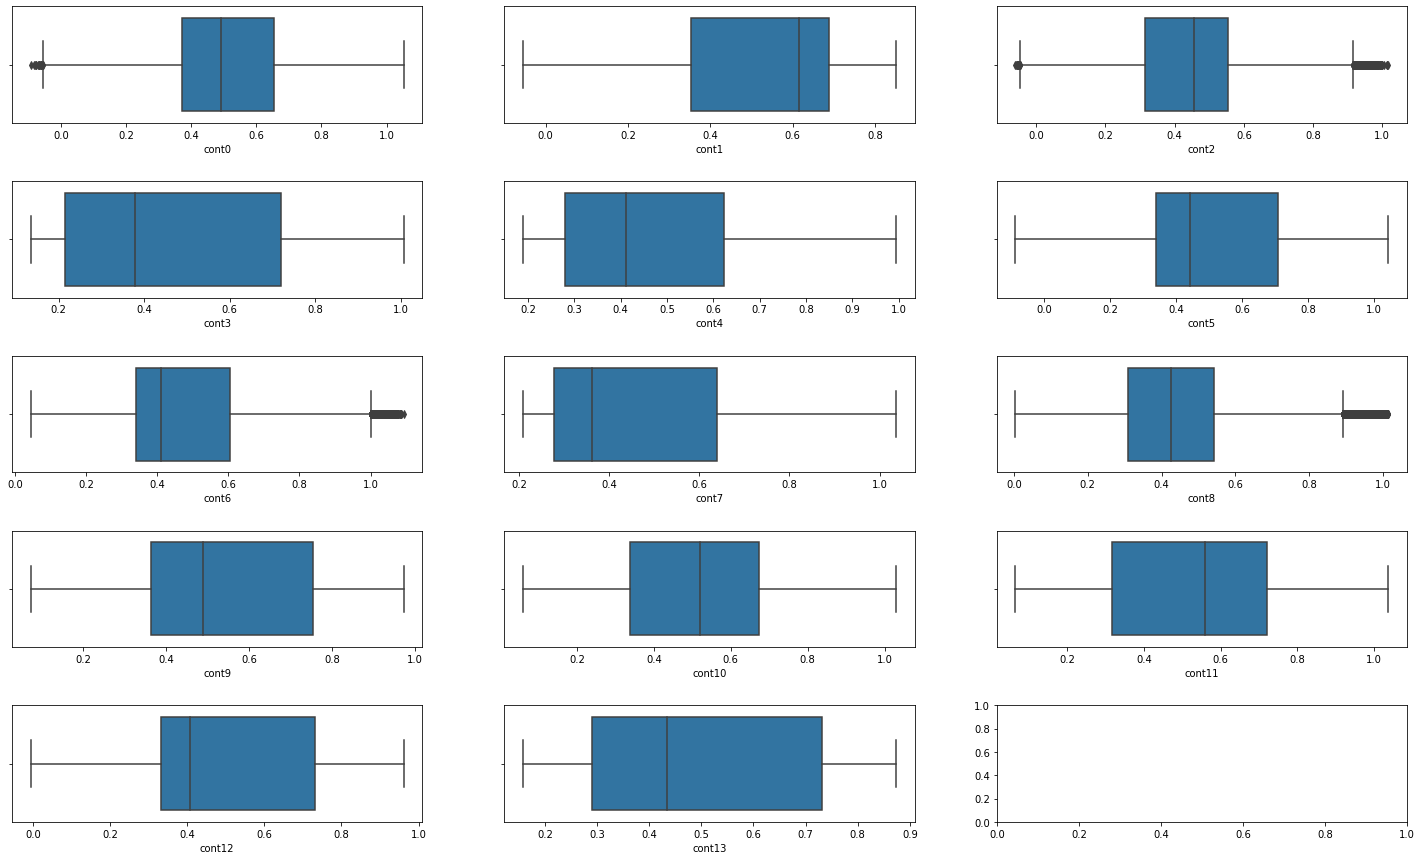

In [5]:
fig, axes = plt.subplots(5, 3, figsize=(25, 15))
sns.boxplot(x='cont0', data=train_df, ax=axes[0,0])
sns.boxplot(x='cont1', data=train_df, ax=axes[0,1])
sns.boxplot(x='cont2', data=train_df, ax=axes[0,2])
sns.boxplot(x='cont3', data=train_df, ax=axes[1,0])
sns.boxplot(x='cont4', data=train_df, ax=axes[1,1])
sns.boxplot(x='cont5', data=train_df, ax=axes[1,2])
sns.boxplot(x='cont6', data=train_df, ax=axes[2,0])
sns.boxplot(x='cont7', data=train_df, ax=axes[2,1])
sns.boxplot(x='cont8', data=train_df, ax=axes[2,2])
sns.boxplot(x='cont9', data=train_df, ax=axes[3,0])
sns.boxplot(x='cont10', data=train_df, ax=axes[3,1])
sns.boxplot(x='cont11', data=train_df, ax=axes[3,2])
sns.boxplot(x='cont12', data=train_df, ax=axes[4,0])
sns.boxplot(x='cont13', data=train_df, ax=axes[4,1])
fig.subplots_adjust(hspace=0.5)
plt.show()

--------------------

*Count of outliers on the low side for cont0 and cont2 are less than 1% of the data. However the up side outliers for cont2, cont6, and cont8 are signficant so opting not to drop outliers. Use robust scaler on cont0, cont2, cont6, and cont8. Use MinMax scaler for remaining continuous features.*

-----------------

### Scale continuous features

In [6]:
train_df.columns

Index(['id', 'cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7',
       'cat8', 'cat9', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5',
       'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12',
       'cont13', 'target'],
      dtype='object')

In [7]:
robust = ['cont0', 'cont2', 'cont6', 'cont8']
min_max = ['cont1', 'cont3', 'cont4', 'cont5', 'cont7', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13']

In [8]:
r_scaler = RobustScaler() 
r_scaler.fit(train_df[robust])
train_df[robust] = r_scaler.transform(train_df[robust])
train_df.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,A,B,A,A,B,D,A,E,C,...,0.881122,0.043732,0.741413,2.018280,0.802461,0.724417,0.701915,0.877618,0.719903,6.994023
1,2,B,A,A,A,B,B,A,E,A,...,0.440011,-0.241574,0.278495,0.719764,0.546056,0.613252,0.741289,0.326679,0.808464,8.071256
2,3,A,A,A,C,B,D,A,B,C,...,0.914155,-0.153161,0.832564,1.888681,0.825251,0.264104,0.695561,0.869133,0.828352,5.760456
3,4,A,A,A,C,B,D,A,E,G,...,0.934138,0.638699,0.407313,1.899329,0.794402,0.494269,0.698125,0.809799,0.614766,7.806457
4,6,A,B,A,A,B,B,A,E,C,...,0.382600,1.119159,0.325193,0.065125,0.462146,0.724447,0.683073,0.343457,0.297743,6.868974


In [9]:
mm_scaler = MinMaxScaler()
mm_scaler.fit(train_df[min_max])
train_df[min_max] = mm_scaler.transform(train_df[min_max])
train_df.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,A,B,A,A,B,D,A,E,C,...,0.855691,0.043732,0.643496,2.018280,0.811322,0.685241,0.654854,0.913387,0.785206,6.994023
1,2,B,A,A,A,B,B,A,E,A,...,0.465907,-0.241574,0.084307,0.719764,0.526128,0.570654,0.695283,0.343629,0.908989,8.071256
2,3,A,A,A,C,B,D,A,B,C,...,0.884880,-0.153161,0.753604,1.888681,0.836672,0.210755,0.648330,0.904611,0.936786,5.760456
3,4,A,A,A,C,B,D,A,E,G,...,0.902538,0.638699,0.239914,1.899329,0.802359,0.448007,0.650962,0.843251,0.638256,7.806457
4,6,A,B,A,A,B,B,A,E,C,...,0.415176,1.119159,0.140716,0.065125,0.432796,0.685273,0.635506,0.360980,0.195151,6.868974


### Encode categorical features

In [10]:
train_df.cat0.unique()

array(['A', 'B'], dtype=object)

In [11]:
ohe0 = OneHotEncoder(sparse = False) 
ohe0.fit(train_df[['cat0']])
cat0_encoded = ohe0.transform(train_df[['cat0']]) 
train_df['cat0_a'],train_df["cat0_b"] = cat0_encoded.T 
train_df.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target,cat0_a,cat0_b
0,1,A,B,A,A,B,D,A,E,C,...,0.643496,2.018280,0.811322,0.685241,0.654854,0.913387,0.785206,6.994023,1.0,0.0
1,2,B,A,A,A,B,B,A,E,A,...,0.084307,0.719764,0.526128,0.570654,0.695283,0.343629,0.908989,8.071256,0.0,1.0
2,3,A,A,A,C,B,D,A,B,C,...,0.753604,1.888681,0.836672,0.210755,0.648330,0.904611,0.936786,5.760456,1.0,0.0
3,4,A,A,A,C,B,D,A,E,G,...,0.239914,1.899329,0.802359,0.448007,0.650962,0.843251,0.638256,7.806457,1.0,0.0
4,6,A,B,A,A,B,B,A,E,C,...,0.140716,0.065125,0.432796,0.685273,0.635506,0.360980,0.195151,6.868974,1.0,0.0


In [12]:
train_df.drop(columns='cat0', inplace=True)
train_df.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target,cat0_a,cat0_b
0,1,B,A,A,B,D,A,E,C,I,...,0.643496,2.018280,0.811322,0.685241,0.654854,0.913387,0.785206,6.994023,1.0,0.0
1,2,A,A,A,B,B,A,E,A,F,...,0.084307,0.719764,0.526128,0.570654,0.695283,0.343629,0.908989,8.071256,0.0,1.0
2,3,A,A,C,B,D,A,B,C,N,...,0.753604,1.888681,0.836672,0.210755,0.648330,0.904611,0.936786,5.760456,1.0,0.0
3,4,A,A,C,B,D,A,E,G,K,...,0.239914,1.899329,0.802359,0.448007,0.650962,0.843251,0.638256,7.806457,1.0,0.0
4,6,B,A,A,B,B,A,E,C,F,...,0.140716,0.065125,0.432796,0.685273,0.635506,0.360980,0.195151,6.868974,1.0,0.0


In [13]:
train_df.cat1.unique()

array(['B', 'A'], dtype=object)

In [14]:
ohe1 = OneHotEncoder(sparse = False) 
ohe1.fit(train_df[['cat1']])
cat1_encoded = ohe1.transform(train_df[['cat1']]) 
train_df['cat1_a'],train_df["cat1_b"] = cat1_encoded.T 
train_df.drop(columns='cat1', inplace=True)
train_df.head()

,id,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,...,cont9,cont10,cont11,cont12,cont13,target,cat0_a,cat0_b,cat1_a,cat1_b
0,1,A,A,B,D,A,E,C,I,1.515719,...,0.811322,0.685241,0.654854,0.913387,0.785206,6.994023,1.0,0.0,0.0,1.0
1,2,A,A,B,B,A,E,A,F,-0.191956,...,0.526128,0.570654,0.695283,0.343629,0.908989,8.071256,0.0,1.0,1.0,0.0
2,3,A,C,B,D,A,B,C,N,0.844056,...,0.836672,0.210755,0.648330,0.904611,0.936786,5.760456,1.0,0.0,1.0,0.0
3,4,A,C,B,D,A,E,G,K,0.748864,...,0.802359,0.448007,0.650962,0.843251,0.638256,7.806457,1.0,0.0,1.0,0.0
4,6,A,A,B,B,A,E,C,F,-0.021612,...,0.432796,0.685273,0.635506,0.360980,0.195151,6.868974,1.0,0.0,0.0,1.0


In [15]:
train_df.cat2.unique()

array(['A', 'B'], dtype=object)

In [16]:
ohe2 = OneHotEncoder(sparse = False) 
ohe2.fit(train_df[['cat2']])
cat2_encoded = ohe2.transform(train_df[['cat2']]) 
train_df['cat2_a'],train_df["cat2_b"] = cat2_encoded.T 
train_df.drop(columns='cat2', inplace=True)
train_df.head()

,id,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,...,cont11,cont12,cont13,target,cat0_a,cat0_b,cat1_a,cat1_b,cat2_a,cat2_b
0,1,A,B,D,A,E,C,I,1.515719,0.816091,...,0.654854,0.913387,0.785206,6.994023,1.0,0.0,0.0,1.0,1.0,0.0
1,2,A,B,B,A,E,A,F,-0.191956,0.076438,...,0.695283,0.343629,0.908989,8.071256,0.0,1.0,1.0,0.0,1.0,0.0
2,3,C,B,D,A,B,C,N,0.844056,0.898964,...,0.648330,0.904611,0.936786,5.760456,1.0,0.0,1.0,0.0,1.0,0.0
3,4,C,B,D,A,E,G,K,0.748864,0.911708,...,0.650962,0.843251,0.638256,7.806457,1.0,0.0,1.0,0.0,1.0,0.0
4,6,A,B,B,A,E,C,F,-0.021612,0.765785,...,0.635506,0.360980,0.195151,6.868974,1.0,0.0,0.0,1.0,1.0,0.0


In [17]:
train_df.cat3.unique()

array(['A', 'C', 'D', 'B'], dtype=object)

In [18]:
ohe3 = OneHotEncoder(sparse = False) 
ohe3.fit(train_df[['cat3']])
cat3_encoded = ohe3.transform(train_df[['cat3']]) 
train_df['cat3_a'],train_df["cat3_b"], train_df["cat3_c"], train_df["cat3_d"] = cat3_encoded.T 
train_df.drop(columns='cat3', inplace=True)
train_df.head()

,id,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,...,cat0_a,cat0_b,cat1_a,cat1_b,cat2_a,cat2_b,cat3_a,cat3_b,cat3_c,cat3_d
0,1,B,D,A,E,C,I,1.515719,0.816091,-1.382623,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1,2,B,B,A,E,A,F,-0.191956,0.076438,-0.414735,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,3,B,D,A,B,C,N,0.844056,0.898964,-0.010912,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,4,B,D,A,E,G,K,0.748864,0.911708,-1.260978,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,6,B,B,A,E,C,F,-0.021612,0.765785,0.161776,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


In [19]:
train_df.cat4.unique()

array(['B', 'C', 'A', 'D'], dtype=object)

In [20]:
ohe4 = OneHotEncoder(sparse = False) 
ohe4.fit(train_df[['cat4']])
cat4_encoded = ohe4.transform(train_df[['cat4']]) 
train_df['cat4_a'],train_df["cat4_b"], train_df["cat4_c"], train_df["cat4_d"] = cat4_encoded.T 
train_df.drop(columns='cat4', inplace=True)
train_df.head()

,id,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,...,cat2_a,cat2_b,cat3_a,cat3_b,cat3_c,cat3_d,cat4_a,cat4_b,cat4_c,cat4_d
0,1,D,A,E,C,I,1.515719,0.816091,-1.382623,0.095360,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2,B,A,E,A,F,-0.191956,0.076438,-0.414735,0.816060,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,D,A,B,C,N,0.844056,0.898964,-0.010912,0.778047,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,4,D,A,E,G,K,0.748864,0.911708,-1.260978,0.686162,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,6,B,A,E,C,F,-0.021612,0.765785,0.161776,0.251719,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [21]:
train_df.cat5.unique()

array(['D', 'B', 'A', 'C'], dtype=object)

In [22]:
ohe5 = OneHotEncoder(sparse = False) 
ohe5.fit(train_df[['cat5']])
cat5_encoded = ohe5.transform(train_df[['cat5']]) 
train_df['cat5_a'],train_df["cat5_b"], train_df["cat5_c"], train_df["cat5_d"] = cat5_encoded.T 
train_df.drop(columns='cat5', inplace=True)
train_df.head()

,id,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,...,cat3_c,cat3_d,cat4_a,cat4_b,cat4_c,cat4_d,cat5_a,cat5_b,cat5_c,cat5_d
0,1,A,E,C,I,1.515719,0.816091,-1.382623,0.095360,0.114564,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,A,E,A,F,-0.191956,0.076438,-0.414735,0.816060,0.115723,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,A,B,C,N,0.844056,0.898964,-0.010912,0.778047,0.129890,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,A,E,G,K,0.748864,0.911708,-1.260978,0.686162,0.721352,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,6,A,E,C,F,-0.021612,0.765785,0.161776,0.251719,0.111686,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [23]:
train_df.cat6.unique()

array(['A', 'B', 'D', 'C', 'E', 'I', 'G', 'H'], dtype=object)

In [24]:
ohe6 = OneHotEncoder(sparse = False) 
ohe6.fit(train_df[['cat6']])
cat6_encoded = ohe6.transform(train_df[['cat6']]) 
train_df['cat6_a'],train_df["cat6_b"], train_df["cat6_c"], train_df["cat6_d"], train_df["cat6_e"], \
train_df["cat6_g"], train_df["cat6_h"], train_df["cat6_i"] = cat6_encoded.T 
train_df.drop(columns='cat6', inplace=True)
train_df.head()

,id,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,...,cat5_c,cat5_d,cat6_a,cat6_b,cat6_c,cat6_d,cat6_e,cat6_g,cat6_h,cat6_i
0,1,E,C,I,1.515719,0.816091,-1.382623,0.095360,0.114564,0.855691,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,E,A,F,-0.191956,0.076438,-0.414735,0.816060,0.115723,0.465907,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,B,C,N,0.844056,0.898964,-0.010912,0.778047,0.129890,0.884880,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,E,G,K,0.748864,0.911708,-1.260978,0.686162,0.721352,0.902538,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6,E,C,F,-0.021612,0.765785,0.161776,0.251719,0.111686,0.415176,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
train_df.cat7.unique()

array(['E', 'B', 'D', 'G', 'F', 'A', 'C', 'I'], dtype=object)

In [26]:
ohe7 = OneHotEncoder(sparse = False) 
ohe7.fit(train_df[['cat7']])
cat7_encoded = ohe7.transform(train_df[['cat7']]) 
train_df['cat7_a'],train_df["cat7_b"], train_df["cat7_c"], train_df["cat7_d"], train_df["cat7_e"], \
train_df["cat7_f"], train_df["cat7_g"], train_df["cat7_i"] = cat7_encoded.T 
train_df.drop(columns='cat7', inplace=True)
train_df.head()

,id,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,...,cat6_h,cat6_i,cat7_a,cat7_b,cat7_c,cat7_d,cat7_e,cat7_f,cat7_g,cat7_i
0,1,C,I,1.515719,0.816091,-1.382623,0.095360,0.114564,0.855691,0.043732,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2,A,F,-0.191956,0.076438,-0.414735,0.816060,0.115723,0.465907,-0.241574,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3,C,N,0.844056,0.898964,-0.010912,0.778047,0.129890,0.884880,-0.153161,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,G,K,0.748864,0.911708,-1.260978,0.686162,0.721352,0.902538,0.638699,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,6,C,F,-0.021612,0.765785,0.161776,0.251719,0.111686,0.415176,1.119159,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [27]:
train_df.cat8.unique()

array(['C', 'A', 'G', 'E', 'D', 'F', 'B'], dtype=object)

In [28]:
ohe8 = OneHotEncoder(sparse = False) 
ohe8.fit(train_df[['cat8']])
cat8_encoded = ohe8.transform(train_df[['cat8']]) 
train_df['cat8_a'],train_df["cat8_b"], train_df["cat8_c"], train_df["cat8_d"], train_df["cat8_e"], \
train_df["cat8_f"], train_df["cat8_g"] = cat8_encoded.T 
train_df.drop(columns='cat8', inplace=True)
train_df.head()

,id,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,...,cat7_f,cat7_g,cat7_i,cat8_a,cat8_b,cat8_c,cat8_d,cat8_e,cat8_f,cat8_g
0,1,I,1.515719,0.816091,-1.382623,0.095360,0.114564,0.855691,0.043732,0.643496,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2,F,-0.191956,0.076438,-0.414735,0.816060,0.115723,0.465907,-0.241574,0.084307,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,N,0.844056,0.898964,-0.010912,0.778047,0.129890,0.884880,-0.153161,0.753604,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4,K,0.748864,0.911708,-1.260978,0.686162,0.721352,0.902538,0.638699,0.239914,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,6,F,-0.021612,0.765785,0.161776,0.251719,0.111686,0.415176,1.119159,0.140716,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [34]:
train_df.cat9.unique()

array(['I', 'F', 'N', 'K', 'B', 'L', 'G', 'H', 'O', 'A', 'J', 'M', 'C',
       'D', 'E'], dtype=object)

In [35]:
ohe9 = OneHotEncoder(sparse = False) 
ohe9.fit(train_df[['cat9']])
cat9_encoded = ohe9.transform(train_df[['cat9']]) 
train_df['cat9_a'],train_df["cat9_b"], train_df["cat9_c"], train_df["cat9_d"], train_df["cat9_e"], \
train_df["cat9_f"], train_df["cat9_g"], train_df["cat9_h"], train_df["cat9_i"], train_df["cat9_j"], \
train_df["cat9_k"], train_df["cat9_l"], train_df["cat9_m"], train_df["cat9_n"], train_df["cat9_o"] = cat9_encoded.T 
train_df.drop(columns='cat9', inplace=True)
train_df.head()

,id,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,...,cat9_f,cat9_g,cat9_h,cat9_i,cat9_j,cat9_k,cat9_l,cat9_m,cat9_n,cat9_o
0,1,1.515719,0.816091,-1.382623,0.095360,0.114564,0.855691,0.043732,0.643496,2.018280,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,-0.191956,0.076438,-0.414735,0.816060,0.115723,0.465907,-0.241574,0.084307,0.719764,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.844056,0.898964,-0.010912,0.778047,0.129890,0.884880,-0.153161,0.753604,1.888681,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,0.748864,0.911708,-1.260978,0.686162,0.721352,0.902538,0.638699,0.239914,1.899329,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,6,-0.021612,0.765785,0.161776,0.251719,0.111686,0.415176,1.119159,0.140716,0.065125,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Feature selection

#### Check for correlation

<AxesSubplot:>

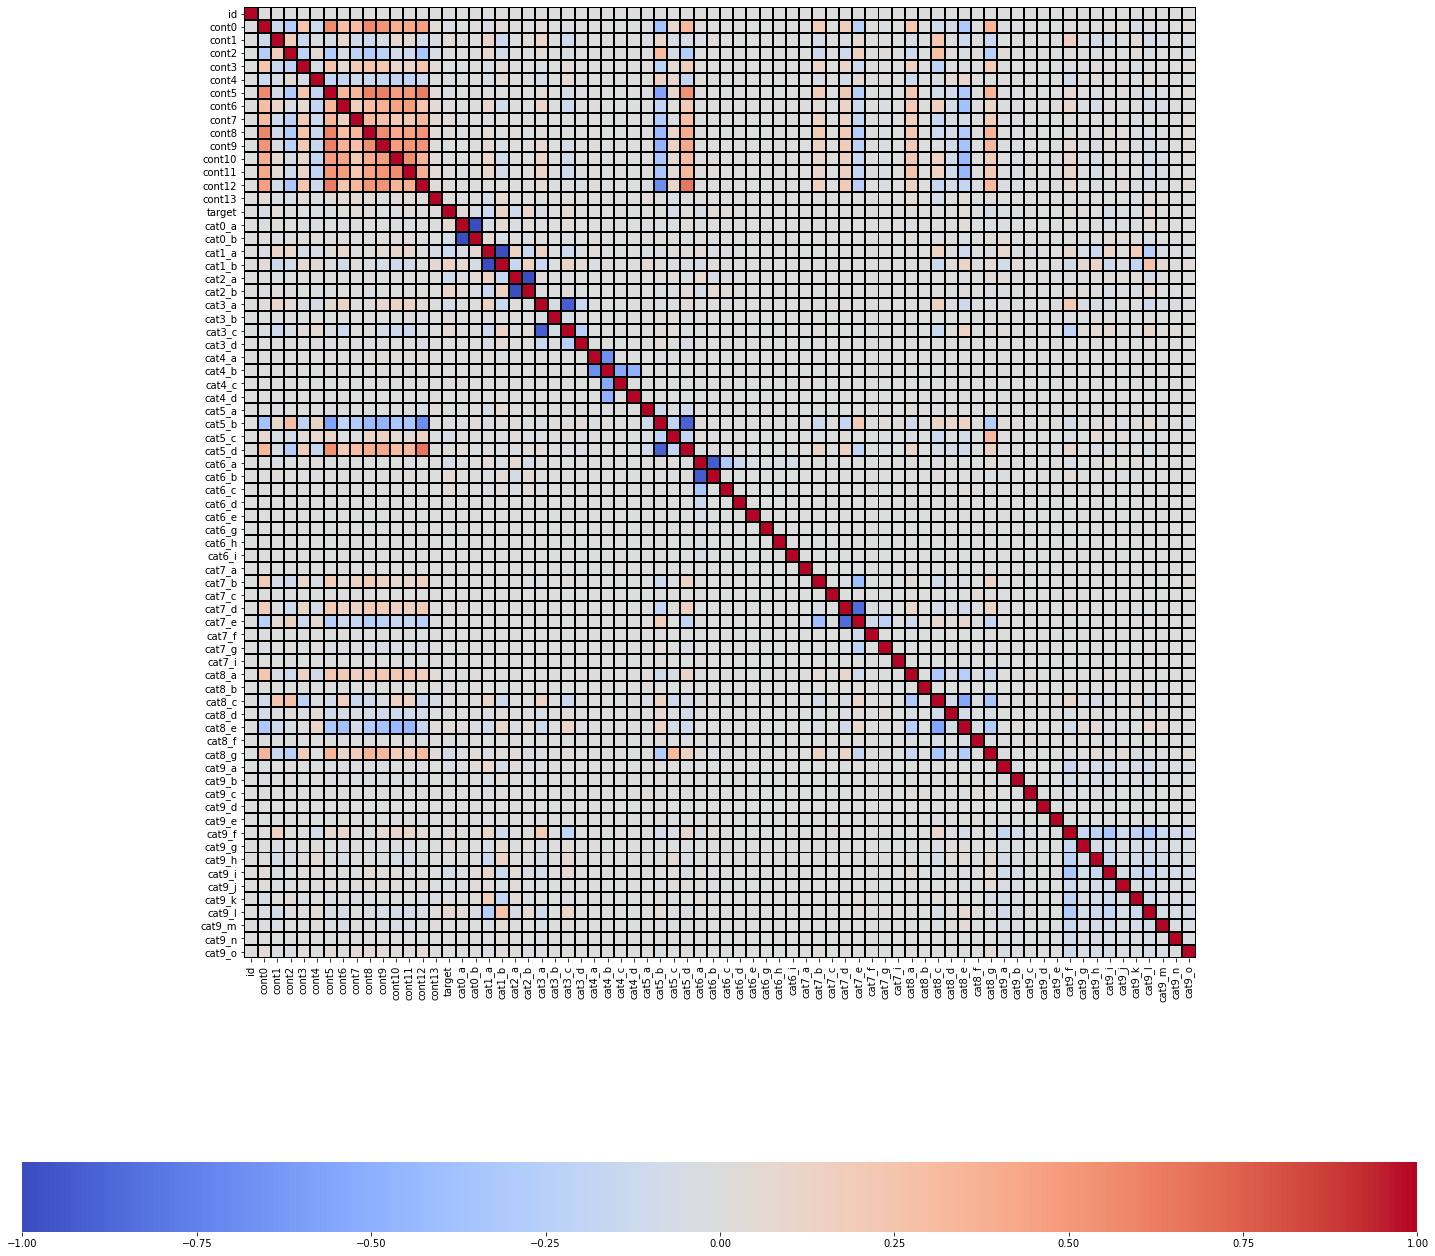

In [42]:
corr = train_df.corr()
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        ax=ax, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm',
        linewidths=1, linecolor='black',
        cbar_kws= {'orientation': 'horizontal'}, 
        square=True)

In [44]:
corr_df = corr.unstack().reset_index()
corr_df.columns = ['feature_1','feature_2', 'correlation']
corr_df.sort_values(by="correlation",ascending=False, inplace=True)
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head()

,feature_1,feature_2,correlation
969,cont12,cat5_d,0.659916
2389,cat5_d,cont12,0.659916
942,cont12,cont5,0.631926
445,cont5,cont12,0.631926
726,cont9,cont5,0.615836


-----------

*The highest feature correlation is ~0.66. Since there aren't many strongly correlated features (over 0.8), I decided to keep all of features based on correlation and check feature importance*

---------------

#### Check feature importance

In [59]:
X = train_df.drop(columns='target')
y = train_df.target

In [52]:
model = LinearRegression() 
scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error') # Cross validate
scores.mean()

-0.8637482861250723

In [50]:
model = LinearRegression().fit(X, y)
permutation_score = permutation_importance(model, X, y)
importance_df = pd.DataFrame(np.vstack((X.columns,
                                        permutation_score.importances_mean)).T)
importance_df.columns=['feature','score decrease']

importance_df.sort_values(by="score decrease", ascending = False)

,feature,score decrease
9,cont8,0.011589
1,cont0,0.00901
6,cont5,0.007568
12,cont11,0.0071
55,cat8_g,0.004995
...,...,...
41,cat7_a,0.000001
25,cat4_a,0.0
0,id,0.0
68,cat9_m,-0.0


In [53]:
weak_df = importance_df.sort_values(by="score decrease", ascending = True).head(16)
weak_df

,feature,score decrease
50,cat8_b,-0.0
68,cat9_m,-0.0
0,id,0.0
25,cat4_a,0.0
41,cat7_a,0.000001
38,cat6_g,0.000001
39,cat6_h,0.000001
46,cat7_f,0.000001
36,cat6_d,0.000001
43,cat7_c,0.000002


In [54]:
weak_df.feature.unique()

array(['cat8_b', 'cat9_m', 'id', 'cat4_a', 'cat7_a', 'cat6_g', 'cat6_h',
       'cat7_f', 'cat6_d', 'cat7_c', 'cat9_n', 'cat9_c', 'cat6_i',
       'cat9_d', 'cat9_k', 'cat6_e'], dtype=object)

In [60]:
X = X.drop(columns=['cat8_b', 'cat9_m', 'id', 'cat4_a', 'cat7_a', 'cat6_g', 'cat6_h',
       'cat7_f', 'cat6_d', 'cat7_c', 'cat9_n', 'cat9_c', 'cat6_i',
       'cat9_d', 'cat9_k', 'cat6_e'])
model = LinearRegression() 
scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error') # Cross validate
scores.mean()
X.head()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,...,cat9_a,cat9_b,cat9_e,cat9_f,cat9_g,cat9_h,cat9_i,cat9_j,cat9_l,cat9_o
0,1.515719,0.816091,-1.382623,0.095360,0.114564,0.855691,0.043732,0.643496,2.018280,0.811322,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.191956,0.076438,-0.414735,0.816060,0.115723,0.465907,-0.241574,0.084307,0.719764,0.526128,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.844056,0.898964,-0.010912,0.778047,0.129890,0.884880,-0.153161,0.753604,1.888681,0.836672,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.748864,0.911708,-1.260978,0.686162,0.721352,0.902538,0.638699,0.239914,1.899329,0.802359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.021612,0.765785,0.161776,0.251719,0.111686,0.415176,1.119159,0.140716,0.065125,0.432796,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
strong_df = importance_df.sort_values(by="score decrease", ascending = False).head(16)
strong_df

,feature,score decrease
9,cont8,0.011589
1,cont0,0.00901
6,cont5,0.007568
12,cont11,0.0071
55,cat8_g,0.004995
18,cat1_b,0.004431
17,cat1_a,0.004431
64,cat9_i,0.003828
67,cat9_l,0.00362
2,cont1,0.003187


In [57]:
strong_df.feature.unique()

array(['cont8', 'cont0', 'cont5', 'cont11', 'cat8_g', 'cat1_b', 'cat1_a',
       'cat9_i', 'cat9_l', 'cont1', 'cat5_b', 'cat2_a', 'cat2_b',
       'cat3_a', 'cat7_e', 'cat5_d'], dtype=object)

In [58]:
# X = X[['cont8', 'cont0', 'cont5', 'cont11', 'cat8_g', 'cat1_b', 'cat1_a',
#        'cat9_i', 'cat9_l', 'cont1', 'cat5_b', 'cat2_a', 'cat2_b',
#        'cat3_a', 'cat7_e', 'cat5_d']]
# model = LinearRegression() 
# scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error') # Cross validate
# scores.mean()

-0.867446007690982

------------

*Tried dropping 20% weakest features vs. keeping 20% strongest features. Too much information is lost with option B so going with dropping 20% weakest features.*

-----------

In [62]:
# Save progress

X.to_csv('data/X_train.csv', index=False)
y.to_csv('data/y_train.csv', index=False)

### Complete same steps on test data

In [49]:
# Check for duplicates

print(len(test_df))
test_df = test_df.drop_duplicates()
print(len(test_df))

200000
200000


In [50]:
# Check for missing values

test_df.isnull().sum().sort_values(ascending=False)

id        0
cont2     0
cont12    0
cont11    0
cont10    0
cont9     0
cont8     0
cont7     0
cont6     0
cont5     0
cont4     0
cont3     0
cont1     0
cat0      0
cont0     0
cat9      0
cat8      0
cat7      0
cat6      0
cat5      0
cat4      0
cat3      0
cat2      0
cat1      0
cont13    0
dtype: int64

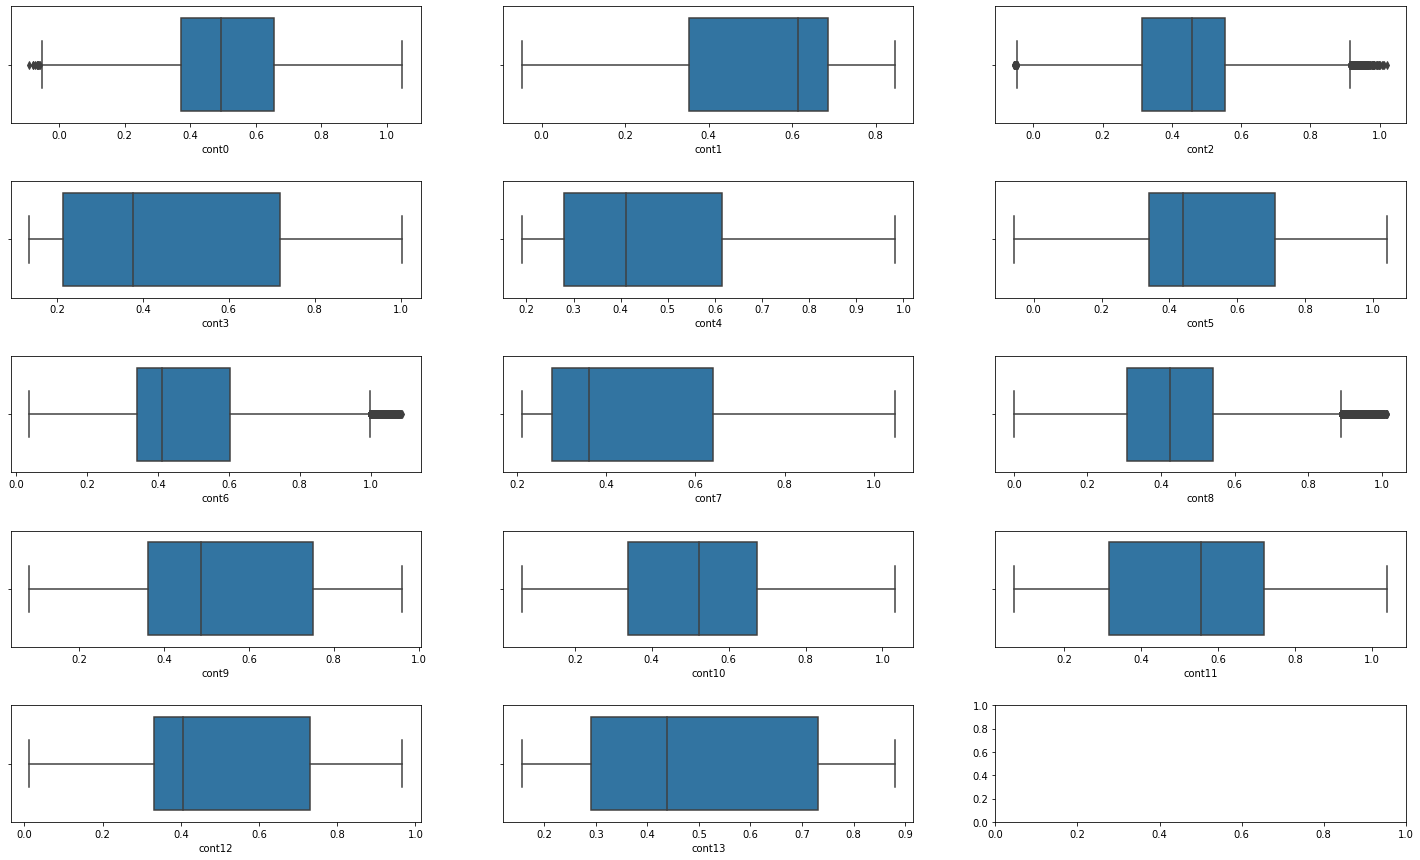

In [51]:
# Check for outliers

fig, axes = plt.subplots(5, 3, figsize=(25, 15))
sns.boxplot(x='cont0', data=test_df, ax=axes[0,0])
sns.boxplot(x='cont1', data=test_df, ax=axes[0,1])
sns.boxplot(x='cont2', data=test_df, ax=axes[0,2])
sns.boxplot(x='cont3', data=test_df, ax=axes[1,0])
sns.boxplot(x='cont4', data=test_df, ax=axes[1,1])
sns.boxplot(x='cont5', data=test_df, ax=axes[1,2])
sns.boxplot(x='cont6', data=test_df, ax=axes[2,0])
sns.boxplot(x='cont7', data=test_df, ax=axes[2,1])
sns.boxplot(x='cont8', data=test_df, ax=axes[2,2])
sns.boxplot(x='cont9', data=test_df, ax=axes[3,0])
sns.boxplot(x='cont10', data=test_df, ax=axes[3,1])
sns.boxplot(x='cont11', data=test_df, ax=axes[3,2])
sns.boxplot(x='cont12', data=test_df, ax=axes[4,0])
sns.boxplot(x='cont13', data=test_df, ax=axes[4,1])
fig.subplots_adjust(hspace=0.5)
plt.show()

In [52]:
# Scale continuous features - robust scaler

r_scaler = RobustScaler() 
r_scaler.fit(test_df[robust])
test_df[robust] = r_scaler.transform(test_df[robust])
test_df.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,0,A,B,A,C,B,D,A,E,E,...,0.701679,0.595507,-0.467832,0.279884,-0.960400,0.242654,0.285147,0.264308,0.653654,0.302448
1,5,A,B,A,C,B,D,A,E,C,...,0.277480,0.479552,-0.047920,0.476742,1.855678,0.516393,0.562065,0.730542,0.318492,0.736251
2,15,A,B,A,C,B,D,A,E,C,...,0.279508,0.676395,1.083683,0.253316,0.693966,0.548555,0.836193,0.759788,0.333572,0.273905
3,16,A,A,B,A,B,D,A,E,E,...,0.479503,0.759875,-0.645878,0.298074,0.072737,0.596746,0.414131,0.255382,0.589080,0.311625
4,17,A,B,A,A,B,B,A,E,E,...,0.757845,0.210232,-0.304696,0.616663,-1.096976,0.263235,0.710961,0.224045,0.285860,0.794931


In [53]:
# Scale continuous features - MinMax scaler

mm_scaler = MinMaxScaler()
mm_scaler.fit(test_df[min_max])
test_df[min_max] = mm_scaler.transform(test_df[min_max])
test_df.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,0,A,B,A,C,B,D,A,E,E,...,0.646458,0.594293,-0.467832,0.082901,-0.960400,0.181973,0.230258,0.200179,0.672012,0.202090
1,5,A,B,A,C,B,D,A,E,C,...,0.110513,0.488834,-0.047920,0.318204,1.855678,0.493316,0.515667,0.681469,0.320500,0.801660
2,15,A,B,A,C,B,D,A,E,C,...,0.113075,0.667858,1.083683,0.051145,0.693966,0.529895,0.798202,0.711660,0.336316,0.162641
3,16,A,A,B,A,B,D,A,E,E,...,0.365754,0.743781,-0.645878,0.104644,0.072737,0.584707,0.363196,0.190965,0.604288,0.214774
4,17,A,B,A,A,B,B,A,E,E,...,0.717419,0.243894,-0.304696,0.485452,-1.096976,0.205381,0.669130,0.158616,0.286277,0.882763


In [54]:
# Encode categorical features

test_df.cat0.unique()

array(['A', 'B'], dtype=object)

In [55]:
ohe0 = OneHotEncoder(sparse = False) 
ohe0.fit(test_df[['cat0']])
cat0_encoded = ohe0.transform(test_df[['cat0']]) 
test_df['cat0_a'],test_df["cat0_b"] = cat0_encoded.T 
test_df.drop(columns='cat0', inplace=True)
test_df.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cat0_a,cat0_b
0,0,B,A,C,B,D,A,E,E,G,...,-0.467832,0.082901,-0.960400,0.181973,0.230258,0.200179,0.672012,0.202090,1.0,0.0
1,5,B,A,C,B,D,A,E,C,L,...,-0.047920,0.318204,1.855678,0.493316,0.515667,0.681469,0.320500,0.801660,1.0,0.0
2,15,B,A,C,B,D,A,E,C,F,...,1.083683,0.051145,0.693966,0.529895,0.798202,0.711660,0.336316,0.162641,1.0,0.0
3,16,A,B,A,B,D,A,E,E,F,...,-0.645878,0.104644,0.072737,0.584707,0.363196,0.190965,0.604288,0.214774,1.0,0.0
4,17,B,A,A,B,B,A,E,E,I,...,-0.304696,0.485452,-1.096976,0.205381,0.669130,0.158616,0.286277,0.882763,1.0,0.0


In [56]:
test_df.cat1.unique()

array(['B', 'A'], dtype=object)

In [57]:
ohe1 = OneHotEncoder(sparse = False) 
ohe1.fit(test_df[['cat1']])
cat1_encoded = ohe1.transform(test_df[['cat1']]) 
test_df['cat1_a'],test_df["cat1_b"] = cat1_encoded.T 
test_df.drop(columns='cat1', inplace=True)
test_df.head()

,id,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,...,cont8,cont9,cont10,cont11,cont12,cont13,cat0_a,cat0_b,cat1_a,cat1_b
0,0,A,C,B,D,A,E,E,G,-0.567908,...,-0.960400,0.181973,0.230258,0.200179,0.672012,0.202090,1.0,0.0,0.0,1.0
1,5,A,C,B,D,A,E,C,L,-0.317526,...,1.855678,0.493316,0.515667,0.681469,0.320500,0.801660,1.0,0.0,0.0,1.0
2,15,A,C,B,D,A,E,C,F,0.133915,...,0.693966,0.529895,0.798202,0.711660,0.336316,0.162641,1.0,0.0,0.0,1.0
3,16,B,A,B,D,A,E,E,F,-0.186435,...,0.072737,0.584707,0.363196,0.190965,0.604288,0.214774,1.0,0.0,1.0,0.0
4,17,A,A,B,B,A,E,E,I,-0.361730,...,-1.096976,0.205381,0.669130,0.158616,0.286277,0.882763,1.0,0.0,0.0,1.0


In [58]:
test_df.cat2.unique()

array(['A', 'B'], dtype=object)

In [59]:
ohe2 = OneHotEncoder(sparse = False) 
ohe2.fit(test_df[['cat2']])
cat2_encoded = ohe2.transform(test_df[['cat2']]) 
test_df['cat2_a'],test_df["cat2_b"] = cat2_encoded.T 
test_df.drop(columns='cat2', inplace=True)
test_df.head()

,id,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,...,cont10,cont11,cont12,cont13,cat0_a,cat0_b,cat1_a,cat1_b,cat2_a,cat2_b
0,0,C,B,D,A,E,E,G,-0.567908,0.670395,...,0.230258,0.200179,0.672012,0.202090,1.0,0.0,0.0,1.0,1.0,0.0
1,5,C,B,D,A,E,C,L,-0.317526,0.744706,...,0.515667,0.681469,0.320500,0.801660,1.0,0.0,0.0,1.0,1.0,0.0
2,15,C,B,D,A,E,C,F,0.133915,0.745355,...,0.798202,0.711660,0.336316,0.162641,1.0,0.0,0.0,1.0,1.0,0.0
3,16,A,B,D,A,E,E,F,-0.186435,0.599089,...,0.363196,0.190965,0.604288,0.214774,1.0,0.0,1.0,0.0,0.0,1.0
4,17,A,B,B,A,E,E,I,-0.361730,0.895997,...,0.669130,0.158616,0.286277,0.882763,1.0,0.0,0.0,1.0,1.0,0.0


In [60]:
test_df.cat3.unique()

array(['C', 'A', 'D', 'B'], dtype=object)

In [61]:
ohe3 = OneHotEncoder(sparse = False) 
ohe3.fit(test_df[['cat3']])
cat3_encoded = ohe3.transform(test_df[['cat3']]) 
test_df['cat3_a'],test_df["cat3_b"], test_df["cat3_c"], test_df["cat3_d"] = cat3_encoded.T 
test_df.drop(columns='cat3', inplace=True)
test_df.head()

,id,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,...,cat0_a,cat0_b,cat1_a,cat1_b,cat2_a,cat2_b,cat3_a,cat3_b,cat3_c,cat3_d
0,0,B,D,A,E,E,G,-0.567908,0.670395,0.122399,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,5,B,D,A,E,C,L,-0.317526,0.744706,-0.666361,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,15,B,D,A,E,C,F,0.133915,0.745355,1.265707,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,16,B,D,A,E,E,F,-0.186435,0.599089,1.078007,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,17,B,B,A,E,E,I,-0.361730,0.895997,-0.589673,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


In [62]:
test_df.cat4.unique()

array(['B', 'A', 'C', 'D'], dtype=object)

In [63]:
ohe4 = OneHotEncoder(sparse = False) 
ohe4.fit(test_df[['cat4']])
cat4_encoded = ohe4.transform(test_df[['cat4']]) 
test_df['cat4_a'],test_df["cat4_b"], test_df["cat4_c"], test_df["cat4_d"] = cat4_encoded.T 
test_df.drop(columns='cat4', inplace=True)
test_df.head()

,id,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,...,cat2_a,cat2_b,cat3_a,cat3_b,cat3_c,cat3_d,cat4_a,cat4_b,cat4_c,cat4_d
0,0,D,A,E,E,G,-0.567908,0.670395,0.122399,0.023265,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,5,D,A,E,C,L,-0.317526,0.744706,-0.666361,0.059415,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,15,D,A,E,C,F,0.133915,0.745355,1.265707,0.073736,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,16,D,A,E,E,F,-0.186435,0.599089,1.078007,0.065598,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,17,B,A,E,E,I,-0.361730,0.895997,-0.589673,0.064361,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [64]:
test_df.cat5.unique()

array(['D', 'B', 'A', 'C'], dtype=object)

In [65]:
ohe5 = OneHotEncoder(sparse = False) 
ohe5.fit(test_df[['cat5']])
cat5_encoded = ohe5.transform(test_df[['cat5']]) 
test_df['cat5_a'],test_df["cat5_b"], test_df["cat5_c"], test_df["cat5_d"] = cat5_encoded.T 
test_df.drop(columns='cat5', inplace=True)
test_df.head()

,id,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,...,cat3_c,cat3_d,cat4_a,cat4_b,cat4_c,cat4_d,cat5_a,cat5_b,cat5_c,cat5_d
0,0,A,E,E,G,-0.567908,0.670395,0.122399,0.023265,0.646458,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,5,A,E,C,L,-0.317526,0.744706,-0.666361,0.059415,0.110513,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,15,A,E,C,F,0.133915,0.745355,1.265707,0.073736,0.113075,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,16,A,E,E,F,-0.186435,0.599089,1.078007,0.065598,0.365754,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,17,A,E,E,I,-0.361730,0.895997,-0.589673,0.064361,0.717419,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [66]:
test_df.cat6.unique()

array(['A', 'B', 'C', 'D', 'E', 'I', 'H'], dtype=object)

In [67]:
ohe6 = OneHotEncoder(sparse = False) 
ohe6.fit(test_df[['cat6']])
cat6_encoded = ohe6.transform(test_df[['cat6']]) 
test_df['cat6_a'],test_df["cat6_b"], test_df["cat6_c"], test_df["cat6_d"], test_df["cat6_e"], \
test_df["cat6_h"], test_df["cat6_i"] = cat6_encoded.T 
test_df.drop(columns='cat6', inplace=True)
test_df.head()

,id,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,...,cat5_b,cat5_c,cat5_d,cat6_a,cat6_b,cat6_c,cat6_d,cat6_e,cat6_h,cat6_i
0,0,E,E,G,-0.567908,0.670395,0.122399,0.023265,0.646458,0.594293,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,E,C,L,-0.317526,0.744706,-0.666361,0.059415,0.110513,0.488834,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,15,E,C,F,0.133915,0.745355,1.265707,0.073736,0.113075,0.667858,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,16,E,E,F,-0.186435,0.599089,1.078007,0.065598,0.365754,0.743781,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17,E,E,I,-0.361730,0.895997,-0.589673,0.064361,0.717419,0.243894,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
test_df.cat7.unique()

array(['E', 'D', 'B', 'G', 'F', 'I', 'A', 'C'], dtype=object)

In [69]:
ohe7 = OneHotEncoder(sparse = False) 
ohe7.fit(test_df[['cat7']])
cat7_encoded = ohe7.transform(test_df[['cat7']]) 
test_df['cat7_a'],test_df["cat7_b"], test_df["cat7_c"], test_df["cat7_d"], test_df["cat7_e"], \
test_df["cat7_f"], test_df["cat7_g"], test_df["cat7_i"] = cat7_encoded.T 
test_df.drop(columns='cat7', inplace=True)
test_df.head()

,id,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,...,cat6_h,cat6_i,cat7_a,cat7_b,cat7_c,cat7_d,cat7_e,cat7_f,cat7_g,cat7_i
0,0,E,G,-0.567908,0.670395,0.122399,0.023265,0.646458,0.594293,-0.467832,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,5,C,L,-0.317526,0.744706,-0.666361,0.059415,0.110513,0.488834,-0.047920,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,15,C,F,0.133915,0.745355,1.265707,0.073736,0.113075,0.667858,1.083683,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,16,E,F,-0.186435,0.599089,1.078007,0.065598,0.365754,0.743781,-0.645878,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,17,E,I,-0.361730,0.895997,-0.589673,0.064361,0.717419,0.243894,-0.304696,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [70]:
test_df.cat8.unique()

array(['E', 'C', 'D', 'G', 'A', 'F', 'B'], dtype=object)

In [71]:
ohe8 = OneHotEncoder(sparse = False) 
ohe8.fit(test_df[['cat8']])
cat8_encoded = ohe8.transform(test_df[['cat8']]) 
test_df['cat8_a'],test_df["cat8_b"], test_df["cat8_c"], test_df["cat8_d"], test_df["cat8_e"], \
test_df["cat8_f"], test_df["cat8_g"] = cat8_encoded.T 
test_df.drop(columns='cat8', inplace=True)
test_df.head()

,id,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,...,cat7_f,cat7_g,cat7_i,cat8_a,cat8_b,cat8_c,cat8_d,cat8_e,cat8_f,cat8_g
0,0,G,-0.567908,0.670395,0.122399,0.023265,0.646458,0.594293,-0.467832,0.082901,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,5,L,-0.317526,0.744706,-0.666361,0.059415,0.110513,0.488834,-0.047920,0.318204,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,15,F,0.133915,0.745355,1.265707,0.073736,0.113075,0.667858,1.083683,0.051145,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,16,F,-0.186435,0.599089,1.078007,0.065598,0.365754,0.743781,-0.645878,0.104644,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,17,I,-0.361730,0.895997,-0.589673,0.064361,0.717419,0.243894,-0.304696,0.485452,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [72]:
test_df.cat9.unique()

array(['G', 'L', 'F', 'I', 'A', 'K', 'M', 'O', 'N', 'H', 'B', 'J', 'C',
       'E', 'D'], dtype=object)

In [73]:
ohe9 = OneHotEncoder(sparse = False) 
ohe9.fit(test_df[['cat9']])
cat9_encoded = ohe9.transform(test_df[['cat9']]) 
test_df['cat9_a'],test_df["cat9_b"], test_df["cat9_c"], test_df["cat9_d"], test_df["cat9_e"], \
test_df["cat9_f"], test_df["cat9_g"], test_df["cat9_h"], test_df["cat9_i"], test_df["cat9_j"], \
test_df["cat9_k"], test_df["cat9_l"], test_df["cat9_m"], test_df["cat9_n"], test_df["cat9_o"] = cat9_encoded.T 
test_df.drop(columns='cat9', inplace=True)
test_df.head()

,id,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,...,cat9_f,cat9_g,cat9_h,cat9_i,cat9_j,cat9_k,cat9_l,cat9_m,cat9_n,cat9_o
0,0,-0.567908,0.670395,0.122399,0.023265,0.646458,0.594293,-0.467832,0.082901,-0.960400,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,-0.317526,0.744706,-0.666361,0.059415,0.110513,0.488834,-0.047920,0.318204,1.855678,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,15,0.133915,0.745355,1.265707,0.073736,0.113075,0.667858,1.083683,0.051145,0.693966,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,16,-0.186435,0.599089,1.078007,0.065598,0.365754,0.743781,-0.645878,0.104644,0.072737,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17,-0.361730,0.895997,-0.589673,0.064361,0.717419,0.243894,-0.304696,0.485452,-1.096976,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
# Feature selection

X_test = test_df
X_test.head()

,id,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,...,cat9_f,cat9_g,cat9_h,cat9_i,cat9_j,cat9_k,cat9_l,cat9_m,cat9_n,cat9_o
0,0,-0.567908,0.670395,0.122399,0.023265,0.646458,0.594293,-0.467832,0.082901,-0.960400,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,-0.317526,0.744706,-0.666361,0.059415,0.110513,0.488834,-0.047920,0.318204,1.855678,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,15,0.133915,0.745355,1.265707,0.073736,0.113075,0.667858,1.083683,0.051145,0.693966,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,16,-0.186435,0.599089,1.078007,0.065598,0.365754,0.743781,-0.645878,0.104644,0.072737,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17,-0.361730,0.895997,-0.589673,0.064361,0.717419,0.243894,-0.304696,0.485452,-1.096976,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
X_test = X_test.drop(columns=['cat8_b', 'cat9_m', 'id', 'cat4_a', 'cat7_a', 'cat6_h',
       'cat7_f', 'cat6_d', 'cat7_c', 'cat9_n', 'cat9_c', 'cat6_i',
       'cat9_d', 'cat9_k', 'cat6_e'])
X_test.head()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,...,cat9_a,cat9_b,cat9_e,cat9_f,cat9_g,cat9_h,cat9_i,cat9_j,cat9_l,cat9_o
0,-0.567908,0.670395,0.122399,0.023265,0.646458,0.594293,-0.467832,0.082901,-0.960400,0.181973,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.317526,0.744706,-0.666361,0.059415,0.110513,0.488834,-0.047920,0.318204,1.855678,0.493316,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.133915,0.745355,1.265707,0.073736,0.113075,0.667858,1.083683,0.051145,0.693966,0.529895,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.186435,0.599089,1.078007,0.065598,0.365754,0.743781,-0.645878,0.104644,0.072737,0.584707,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.361730,0.895997,-0.589673,0.064361,0.717419,0.243894,-0.304696,0.485452,-1.096976,0.205381,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [77]:
# Save progress

X_test.to_csv('data/X_test.csv', index=False)

# Machine Learning Models

## Establish baseline

In [84]:
X = pd.read_csv('data/X_train.csv')
y = pd.read_csv('data/y_train.csv')

# Baseline model
baseline_model = DummyRegressor()

# Cross validate model
cv_results = cross_validate(baseline_model, X, y, cv=5, scoring='neg_mean_squared_error') 
                      
# Cross validation output
cv_results['test_score'].mean()

-0.787290185420595

In [85]:
print('RMSE =', math.sqrt(abs(cv_results['test_score'].mean())))

RMSE = 0.8872937424667183


## Model with XGBRegressor

In [88]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=3)

In [89]:
xgb = XGBRegressor(n_estimators=3, max_depth=3, learning_rate=0.1)
xgb.fit(X_train, y_train, 
        eval_set=[(X_val, y_val)], 
        early_stopping_rounds=5) 
y_pred = xgb.predict(X_val)

[0]	validation_0-rmse:6.32122
[1]	validation_0-rmse:5.70162
[2]	validation_0-rmse:5.14535


In [93]:
xgb_mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
print('RMSE =', math.sqrt(abs(xgb_mse)))

RMSE = 5.14535421495048


In [94]:
%%time

estimator = XGBRegressor()

parameters = {
    'n_estimators': [30, 50, 100],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.001, 0.01, 0.1]
    }

grid_search = GridSearchCV(estimator, parameters, n_jobs=-1, 
                           verbose=2, scoring = "neg_mean_squared_error", refit=True)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Wall time: 23min 9s


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
      

In [95]:
print(f'Best estimator: {grid_search.best_estimator_}')
print(f'Best parameters: {grid_search.best_params_}')

Best estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


In [96]:
y_pred = grid_search.predict(X_val)
mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
print('RMSE =', math.sqrt(abs(mse)))

RMSE = 0.8464456234130507


In [99]:
%%time

# Second iteration

xgb_2 = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, monotone_constraints='()',
             n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

parameters_2 = {
    'n_estimators': [100, 150, 250],
    }

grid_search_2 = GridSearchCV(xgb_2, parameters_2, n_jobs=-1, 
                           verbose=1, scoring = "neg_mean_squared_error", refit=True)

grid_search_2.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Wall time: 6min 56s


GridSearchCV(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.1, max_delta_step=0,
                                    max_depth=5, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_jobs=8,
                                    num_parallel_tree=1, random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, subsample=1,
                                    tree_method='exact', validate_parameters=1,
                                    verbosity=None),
             n_jobs=-1, param_gri

In [100]:
print(f'Best estimator: {grid_search_2.best_estimator_}')
print(f'Best parameters: {grid_search_2.best_params_}')

Best estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=250, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
Best parameters: {'n_estimators': 250}


In [101]:
y_pred_2 = grid_search_2.predict(X_val)
mse_2 = mean_squared_error(y_true=y_val, y_pred=y_pred_2)
print('RMSE =', math.sqrt(abs(mse_2)))

RMSE = 0.8435297762161591


In [102]:
%%time

# Third iteration

xgb_3 = XGBRegressor(learning_rate=0.1, max_depth=5)

parameters_3 = {
    'n_estimators': [250, 350, 450],
    }

grid_search_3 = GridSearchCV(xgb_3, parameters_3, n_jobs=-1, 
                           verbose=1, scoring = "neg_mean_squared_error", refit=True)

grid_search_3.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Wall time: 14min 1s


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
          

In [103]:
print(f'Best estimator: {grid_search_3.best_estimator_}')
print(f'Best parameters: {grid_search_3.best_params_}')

Best estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=350, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
Best parameters: {'n_estimators': 350}


In [104]:
y_pred_3 = grid_search_3.predict(X_val)
mse_3 = mean_squared_error(y_true=y_val, y_pred=y_pred_3)
print('RMSE =', math.sqrt(abs(mse_3)))

RMSE = 0.8434329186368216


### XGBRegressor Learning Curves

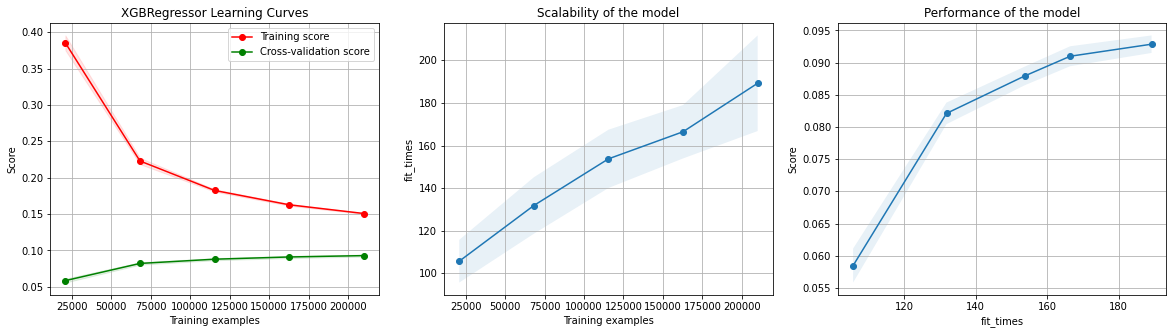

Wall time: 32min 5s


In [113]:
%%time

title = "XGBRegressor Learning Curves"

# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
# XGBRegressor is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=3)

estimator = XGBRegressor(n_estimators=350, learning_rate=0.1, max_depth=5)
    
plot_learning_curve(estimator, title, X, y, axes=None,
                    cv=cv, n_jobs=4)

plt.show()

### XGBRegressor Submission

In [108]:
test = pd.read_csv('data/X_test.csv')
test.head()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,...,cat9_a,cat9_b,cat9_e,cat9_f,cat9_g,cat9_h,cat9_i,cat9_j,cat9_l,cat9_o
0,-0.567908,0.670395,0.122399,0.023265,0.646458,0.594293,-0.467832,0.082901,-0.960400,0.181973,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.317526,0.744706,-0.666361,0.059415,0.110513,0.488834,-0.047920,0.318204,1.855678,0.493316,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.133915,0.745355,1.265707,0.073736,0.113075,0.667858,1.083683,0.051145,0.693966,0.529895,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.186435,0.599089,1.078007,0.065598,0.365754,0.743781,-0.645878,0.104644,0.072737,0.584707,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.361730,0.895997,-0.589673,0.064361,0.717419,0.243894,-0.304696,0.485452,-1.096976,0.205381,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [109]:
submission = pd.read_csv('data/sample_submission.csv')
submission.head()

,id,target
0,0,0.5
1,5,0.5
2,15,0.5
3,16,0.5
4,17,0.5


In [110]:
submission['target'] = grid_search_3.predict(test)
submission.head()

,id,target
0,0,7.719434
1,5,7.778706
2,15,7.617655
3,16,7.578147
4,17,7.414889


In [111]:
submission.to_csv('data/xgb.csv', index=False)

## Model with AdaBoostRegressor

### Tune DecisionTreeRegressor

In [3]:
X = pd.read_csv('data/X_train.csv')
y = pd.read_csv('data/y_train.csv')

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=3)

In [4]:
%%time

dec_tree = DecisionTreeRegressor()

parameters = {
    'criterion': ['mse', 'friedman_mse'],
    'splitter': ['best', 'random'],
    'max_depth': [3, 5]
    }

grid_search = GridSearchCV(dec_tree, parameters, n_jobs=-1, 
                           verbose=1, scoring = "neg_mean_squared_error", refit=True)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Wall time: 1min 16s


GridSearchCV(estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse', 'friedman_mse'],
                         'max_depth': [3, 5], 'splitter': ['best', 'random']},
             scoring='neg_mean_squared_error', verbose=1)

In [5]:
print(f'Best estimator: {grid_search.best_estimator_}')
print(f'Best parameters: {grid_search.best_params_}')

Best estimator: DecisionTreeRegressor(max_depth=5)
Best parameters: {'criterion': 'mse', 'max_depth': 5, 'splitter': 'best'}


In [6]:
y_pred = grid_search.predict(X_val)
mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
print('RMSE =', math.sqrt(abs(mse)))

RMSE = 0.8685492402850901


### Tune AdaBoostRegressor

In [5]:
%%time

estimator = DecisionTreeRegressor(criterion='mse', max_depth=5, splitter='best', random_state=3)
ada = AdaBoostRegressor(base_estimator=estimator)

parameters = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [1, 0.1, 0.01],
    'loss': ['linear', 'square', 'exponential']
    }

grid_search = HalvingGridSearchCV(ada, parameters, n_jobs=-1, 
                           verbose=1, scoring = "neg_mean_squared_error", refit=True)

grid_search.fit(X_train, y_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 7777
max_resources_: 210000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 27
n_resources: 7777
Fitting 5 folds for each of 27 candidates, totalling 135 fits
----------
iter: 1
n_candidates: 9
n_resources: 23331
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 2
n_candidates: 3
n_resources: 69993
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 3
n_candidates: 1
n_resources: 209979
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\users\njeri\.venvs\tabular_comp\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Wall time: 51min 19s


HalvingGridSearchCV(estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5,
                                                                                     random_state=3)),
                    n_jobs=-1,
                    param_grid={'learning_rate': [1, 0.1, 0.01],
                                'loss': ['linear', 'square', 'exponential'],
                                'n_estimators': [50, 100, 150]},
                    refit=<function _refit_callable at 0x0000026869BCBA68>,
                    scoring='neg_mean_squared_error', verbose=1)

In [7]:
print(f'Best estimator: {grid_search.best_estimator_}')
print(f'Best parameters: {grid_search.best_params_}')

Best estimator: AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5,
                                                       random_state=3),
                  learning_rate=0.1, loss='exponential', n_estimators=100)
Best parameters: {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 100}


In [9]:
y_pred = grid_search.predict(X_val)
mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
print('RMSE =', math.sqrt(abs(mse)))

RMSE = 0.864489495071042


## Model with GradientBoostingRegressor

In [11]:
%%time

gbr = GradientBoostingRegressor()

parameters = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],
    'loss': ['ls', 'lad', 'huber']
    }

grid_search = HalvingGridSearchCV(gbr, parameters, n_jobs=-1, 
                           verbose=1, scoring = "neg_mean_squared_error", refit=True)

grid_search.fit(X_train, y_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 7777
max_resources_: 210000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 27
n_resources: 7777
Fitting 5 folds for each of 27 candidates, totalling 135 fits
----------
iter: 1
n_candidates: 9
n_resources: 23331
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 2
n_candidates: 3
n_resources: 69993
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 3
n_candidates: 1
n_resources: 209979
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\users\njeri\.venvs\tabular_comp\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Wall time: 1h 7min 23s


HalvingGridSearchCV(estimator=GradientBoostingRegressor(), n_jobs=-1,
                    param_grid={'learning_rate': [0.1, 0.01, 0.001],
                                'loss': ['ls', 'lad', 'huber'],
                                'n_estimators': [100, 200, 300]},
                    refit=<function _refit_callable at 0x0000026869BCBA68>,
                    scoring='neg_mean_squared_error', verbose=1)

In [12]:
print(f'Best estimator: {grid_search.best_estimator_}')
print(f'Best parameters: {grid_search.best_params_}')

Best estimator: GradientBoostingRegressor(n_estimators=300)
Best parameters: {'learning_rate': 0.1, 'loss': 'ls', 'n_estimators': 300}


In [13]:
y_pred = grid_search.predict(X_val)
mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
print('RMSE =', math.sqrt(abs(mse)))

RMSE = 0.8440764232304617


In [14]:
%%time

## Second iteration

gbr_2 = GradientBoostingRegressor(learning_rate=0.1)

parameters_2 = {
    'n_estimators': [300, 350, 400],
    'subsample': [1, 0.7, 0.4],
    'loss': ['ls', 'quantile']
    }

search_2 = HalvingGridSearchCV(gbr_2, parameters_2, n_jobs=-1, 
                           verbose=1, scoring = "neg_mean_squared_error", refit=True)

search_2.fit(X_train, y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 23333
max_resources_: 210000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 18
n_resources: 23333
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 1
n_candidates: 6
n_resources: 69999
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 2
n_candidates: 2
n_resources: 209997
Fitting 5 folds for each of 2 candidates, totalling 10 fits


c:\users\njeri\.venvs\tabular_comp\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Wall time: 1h 10min 26s


HalvingGridSearchCV(estimator=GradientBoostingRegressor(), n_jobs=-1,
                    param_grid={'loss': ['ls', 'quantile'],
                                'n_estimators': [300, 350, 400],
                                'subsample': [1, 0.7, 0.4]},
                    refit=<function _refit_callable at 0x0000026869BCBA68>,
                    scoring='neg_mean_squared_error', verbose=1)

In [15]:
print(f'Best estimator: {search_2.best_estimator_}')
print(f'Best parameters: {search_2.best_params_}')

Best estimator: GradientBoostingRegressor(n_estimators=350, subsample=0.7)
Best parameters: {'loss': 'ls', 'n_estimators': 350, 'subsample': 0.7}


In [16]:
y_pred_2 = search_2.predict(X_val)
mse_2 = mean_squared_error(y_true=y_val, y_pred=y_pred_2)
print('RMSE =', math.sqrt(abs(mse_2)))

RMSE = 0.8434234165719741


### GBR Submission

In [17]:
test = pd.read_csv('data/X_test.csv')
test.head()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,...,cat9_a,cat9_b,cat9_e,cat9_f,cat9_g,cat9_h,cat9_i,cat9_j,cat9_l,cat9_o
0,-0.567908,0.670395,0.122399,0.023265,0.646458,0.594293,-0.467832,0.082901,-0.960400,0.181973,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.317526,0.744706,-0.666361,0.059415,0.110513,0.488834,-0.047920,0.318204,1.855678,0.493316,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.133915,0.745355,1.265707,0.073736,0.113075,0.667858,1.083683,0.051145,0.693966,0.529895,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.186435,0.599089,1.078007,0.065598,0.365754,0.743781,-0.645878,0.104644,0.072737,0.584707,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.361730,0.895997,-0.589673,0.064361,0.717419,0.243894,-0.304696,0.485452,-1.096976,0.205381,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [18]:
submission = pd.read_csv('data/sample_submission.csv')
submission.head()

,id,target
0,0,0.5
1,5,0.5
2,15,0.5
3,16,0.5
4,17,0.5


In [19]:
submission['target'] = search_2.predict(test)
submission.head()

,id,target
0,0,7.521744
1,5,7.805596
2,15,7.629301
3,16,7.423091
4,17,7.294840


In [20]:
submission.to_csv('data/gbr.csv', index=False)

## Model with Voting Regressor

In [25]:
%%time

xgb = XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=350, random_state=3)
gbr = GradientBoostingRegressor(learning_rate=0.1, loss='ls', n_estimators=350, subsample=0.7)
vr = VotingRegressor(
    estimators=[('xgb', xgb), ('gbr', gbr)],
    n_jobs=-1, verbose=True
    )
vr.fit(X_train, y_train)

c:\users\njeri\.venvs\tabular_comp\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Wall time: 5min 38s


VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=0.1,
                                          max_delta_step=None, max_depth=5,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=350, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=3, reg_alpha=None,
                                   

In [26]:
y_pred = vr.predict(X_val)
mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
print('RMSE =', math.sqrt(abs(mse)))

RMSE = 0.8427787428408751


### Voting Regressor Submission

In [27]:
test = pd.read_csv('data/X_test.csv')
submission = pd.read_csv('data/sample_submission.csv')
submission['target'] = vr.predict(test)
submission.to_csv('data/vr.csv', index=False)

## RandomForest Model

In [3]:
X = pd.read_csv('data/X_train.csv')
y = pd.read_csv('data/y_train.csv')

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=3)

In [9]:
%%time

rf = RandomForestRegressor(n_estimators=300, criterion='mse', max_depth=5)

rf.fit(X_train, y_train)

c:\users\njeri\.venvs\tabular_comp\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Wall time: 9min 40s


RandomForestRegressor(max_depth=5, n_estimators=300)

In [10]:
y_pred = rf.predict(X_val)
mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
print('RMSE =', math.sqrt(abs(mse)))

RMSE = 0.8657956621115992


In [11]:
%%time

# second iteration

rf_2 = RandomForestRegressor(n_estimators=400, criterion='mse', max_depth=5)

rf_2.fit(X_train, y_train)

c:\users\njeri\.venvs\tabular_comp\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Wall time: 12min 47s


RandomForestRegressor(max_depth=5, n_estimators=400)

In [12]:
y_pred_2 = rf_2.predict(X_val)
mse_2 = mean_squared_error(y_true=y_val, y_pred=y_pred_2)
print('RMSE =', math.sqrt(abs(mse_2)))

RMSE = 0.8658817232074387


In [13]:
%%time

# third iteration

rf_3 = RandomForestRegressor(n_estimators=300, criterion='mae', max_depth=5)

rf_3.fit(X_train, y_train)

c:\users\njeri\.venvs\tabular_comp\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


KeyboardInterrupt: 

## LinearSVR vs SGDRegressor with BaggingRegressor

In [15]:
svr = LinearSVR()
svr.fit(X_train, y_train)

c:\users\njeri\.venvs\tabular_comp\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\users\njeri\.venvs\tabular_comp\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR()

In [16]:
y_pred = svr.predict(X_val)
mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
print('RMSE =', math.sqrt(abs(mse)))

RMSE = 0.8671861474128816


In [19]:
sgd = SGDRegressor()
sgd.fit(X_train, y_train)

c:\users\njeri\.venvs\tabular_comp\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SGDRegressor()

In [20]:
y_pred = sgd.predict(X_val)
mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
print('RMSE =', math.sqrt(abs(mse)))

RMSE = 0.8634689818426794


In [24]:
%%time

sgd = SGDRegressor()

parameters = {
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01],
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive']
    }

search = HalvingGridSearchCV(sgd, parameters, n_jobs=-1, 
                           verbose=1, scoring = "neg_mean_squared_error", refit=True)

search.fit(X_train, y_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 7777
max_resources_: 210000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 27
n_resources: 7777
Fitting 5 folds for each of 27 candidates, totalling 135 fits
----------
iter: 1
n_candidates: 9
n_resources: 23331
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 2
n_candidates: 3
n_resources: 69993
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 3
n_candidates: 1
n_resources: 209979
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\users\njeri\.venvs\tabular_comp\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Wall time: 8.26 s


HalvingGridSearchCV(estimator=SGDRegressor(), n_jobs=-1,
                    param_grid={'alpha': [0.0001, 0.001, 0.01],
                                'loss': ['squared_loss', 'huber',
                                         'epsilon_insensitive'],
                                'penalty': ['l2', 'l1', 'elasticnet']},
                    refit=<function _refit_callable at 0x000002B7463FD9D8>,
                    scoring='neg_mean_squared_error', verbose=1)

In [25]:
print(f'Best estimator: {search.best_estimator_}')
print(f'Best parameters: {search.best_params_}')

Best estimator: SGDRegressor(penalty='l1')
Best parameters: {'alpha': 0.0001, 'loss': 'squared_loss', 'penalty': 'l1'}


In [27]:
y_pred = search.predict(X_val)
mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
print('RMSE =', math.sqrt(abs(mse)))

RMSE = 0.8635493998587017


In [29]:
%%time

sgd = SGDRegressor(loss='squared_loss', penalty='l1', alpha=0.0001)
sgd_bag = BaggingRegressor(base_estimator=sgd)

parameters = {
    'n_estimators': [10, 20, 30]
    }

search = HalvingGridSearchCV(sgd_bag, parameters, n_jobs=-1, 
                           verbose=1, scoring = "neg_mean_squared_error", refit=True)

search.fit(X_train, y_train)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 70000
max_resources_: 210000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 3
n_resources: 70000
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 1
n_candidates: 1
n_resources: 210000
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\users\njeri\.venvs\tabular_comp\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Wall time: 1min 16s


HalvingGridSearchCV(estimator=BaggingRegressor(base_estimator=SGDRegressor(penalty='l1')),
                    n_jobs=-1, param_grid={'n_estimators': [10, 20, 30]},
                    refit=<function _refit_callable at 0x000002B7463FD9D8>,
                    scoring='neg_mean_squared_error', verbose=1)

In [30]:
print(f'Best estimator: {search.best_estimator_}')
print(f'Best parameters: {search.best_params_}')

Best estimator: BaggingRegressor(base_estimator=SGDRegressor(penalty='l1'), n_estimators=30)
Best parameters: {'n_estimators': 30}


In [31]:
y_pred = search.predict(X_val)
mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
print('RMSE =', math.sqrt(abs(mse)))

RMSE = 0.8621076823568952


In [32]:
%%time

# Second iteration

sgd = SGDRegressor(loss='squared_loss', penalty='l1', alpha=0.0001)
sgd_bag = BaggingRegressor(base_estimator=sgd)

parameters_2 = {
    'n_estimators': [30, 50, 100]
    }

search_2 = HalvingGridSearchCV(sgd_bag, parameters_2, n_jobs=-1, 
                           verbose=1, scoring = "neg_mean_squared_error", refit=True)

search_2.fit(X_train, y_train)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 70000
max_resources_: 210000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 3
n_resources: 70000
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 1
n_candidates: 1
n_resources: 210000
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\users\njeri\.venvs\tabular_comp\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Wall time: 2min 30s


HalvingGridSearchCV(estimator=BaggingRegressor(base_estimator=SGDRegressor(penalty='l1')),
                    n_jobs=-1, param_grid={'n_estimators': [30, 50, 100]},
                    refit=<function _refit_callable at 0x000002B7463FD9D8>,
                    scoring='neg_mean_squared_error', verbose=1)

In [33]:
print(f'Best estimator: {search_2.best_estimator_}')
print(f'Best parameters: {search_2.best_params_}')

Best estimator: BaggingRegressor(base_estimator=SGDRegressor(penalty='l1'), n_estimators=50)
Best parameters: {'n_estimators': 50}


In [34]:
y_pred_2 = search_2.predict(X_val)
mse_2 = mean_squared_error(y_true=y_val, y_pred=y_pred_2)
print('RMSE =', math.sqrt(abs(mse_2)))

RMSE = 0.862123450612965


## KNeighborsRegressor

In [38]:
%%time

knn = KNeighborsRegressor()

parameters = {
    'n_neighbors': [5, 10, 15],
    'weights': ['uniform', 'distance'],
    'leaf_size': [30, 15, 60]
    }

search = HalvingGridSearchCV(knn, parameters, n_jobs=-1, 
                           verbose=1, scoring = "neg_mean_squared_error", refit=True)

search.fit(X_train, y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 23333
max_resources_: 210000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 18
n_resources: 23333
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 1
n_candidates: 6
n_resources: 69999
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 2
n_candidates: 2
n_resources: 209997
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Wall time: 6h 40min 26s


HalvingGridSearchCV(estimator=KNeighborsRegressor(), n_jobs=-1,
                    param_grid={'leaf_size': [30, 15, 60],
                                'n_neighbors': [5, 10, 15],
                                'weights': ['uniform', 'distance']},
                    refit=<function _refit_callable at 0x000002B7463FD9D8>,
                    scoring='neg_mean_squared_error', verbose=1)

In [40]:
print(f'Best estimator: {search.best_estimator_}')
print(f'Best parameters: {search.best_params_}')

Best estimator: KNeighborsRegressor(n_neighbors=15)
Best parameters: {'leaf_size': 30, 'n_neighbors': 15, 'weights': 'uniform'}


In [41]:
y_pred = search.predict(X_val)
mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
print('RMSE =', math.sqrt(abs(mse)))

RMSE = 0.8879376903101438


## RidgeCV

In [45]:
ridge = RidgeCV()

ridge.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

In [46]:
ridge.get_params()

{'alpha_per_target': False,
 'alphas': array([ 0.1,  1. , 10. ]),
 'cv': None,
 'fit_intercept': True,
 'gcv_mode': None,
 'normalize': False,
 'scoring': None,
 'store_cv_values': False}

In [47]:
y_pred = ridge.predict(X_val)
mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
print('RMSE =', math.sqrt(abs(mse)))

RMSE = 0.861525888168427


### Add bagging

In [48]:
%%time

ridge = RidgeCV()
ridge_bag = BaggingRegressor(base_estimator=ridge)

parameters = {
    'n_estimators': [10, 20, 30]
    }

search = HalvingGridSearchCV(ridge_bag, parameters, n_jobs=-1, 
                           verbose=1, scoring = "neg_mean_squared_error", refit=True)

search.fit(X_train, y_train)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 70000
max_resources_: 210000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 3
n_resources: 70000
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 1
n_candidates: 1
n_resources: 210000
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\users\njeri\.venvs\tabular_comp\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Wall time: 5min 6s


HalvingGridSearchCV(estimator=BaggingRegressor(base_estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]))),
                    n_jobs=-1, param_grid={'n_estimators': [10, 20, 30]},
                    refit=<function _refit_callable at 0x000002B7463FD9D8>,
                    scoring='neg_mean_squared_error', verbose=1)

In [49]:
print(f'Best estimator: {search.best_estimator_}')
print(f'Best parameters: {search.best_params_}')

Best estimator: BaggingRegressor(base_estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ])),
                 n_estimators=30)
Best parameters: {'n_estimators': 30}


In [50]:
y_pred = search.predict(X_val)
mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
print('RMSE =', math.sqrt(abs(mse)))

RMSE = 0.8615317648647828


## Stacking Regressor

In [53]:
%%time

xgb = XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=350, random_state=3)
gbr = GradientBoostingRegressor(learning_rate=0.1, loss='ls', n_estimators=350, subsample=0.7)
sgd = SGDRegressor(penalty='l1')
sgd_bag = BaggingRegressor(base_estimator=sgd, n_estimators=50)
ridge = RidgeCV()
sr = StackingRegressor(
    estimators=[('xgb', xgb), ('gbr', gbr), ('sgd_bag', sgd_bag)],
    final_estimator=ridge,
    n_jobs=-1, verbose=True
    )
sr.fit(X_train, y_train)

c:\users\njeri\.venvs\tabular_comp\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Wall time: 16min 7s


StackingRegressor(estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.1,
                                            max_delta_step=None, max_depth=5,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=350, n_...
                                            random_state=3, reg_alpha=None,
                                            reg_lambda=None,
                     

In [55]:
y_pred = sr.predict(X_val)
mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
print('RMSE =', math.sqrt(abs(mse)))

RMSE = 0.8425540494097691


### Stacking Regressor Submission

In [56]:
test = pd.read_csv('data/X_test.csv')
submission = pd.read_csv('data/sample_submission.csv')
submission['target'] = sr.predict(test)
submission.to_csv('data/sr.csv', index=False)

## Linear Regression

In [4]:
%%time

linear = LinearRegression()

linear.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [93]:
y_pred = linear.predict(X_val)
mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
print('RMSE =', math.sqrt(abs(mse)))

RMSE = 0.8615413454927261


### Add bagging

In [5]:
X = pd.read_csv('data/X_train.csv')
y = pd.read_csv('data/y_train.csv')

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=3)

In [7]:
%%time

linear = LinearRegression()
linear_bag = BaggingRegressor(base_estimator=linear)

parameters = {
    'n_estimators': [10, 20, 30]
    }

search = HalvingGridSearchCV(linear_bag, parameters, n_jobs=-1, 
                           verbose=1, scoring = "neg_mean_squared_error", refit=True)

search.fit(X_train, y_train)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 70000
max_resources_: 210000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 3
n_resources: 70000
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 1
n_candidates: 1
n_resources: 210000
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\users\njeri\.venvs\tabular_comp\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Wall time: 2min 55s


HalvingGridSearchCV(estimator=BaggingRegressor(base_estimator=LinearRegression()),
                    n_jobs=-1, param_grid={'n_estimators': [10, 20, 30]},
                    refit=<function _refit_callable at 0x000001D1664AE828>,
                    scoring='neg_mean_squared_error', verbose=1)

In [8]:
print(f'Best estimator: {search.best_estimator_}')
print(f'Best parameters: {search.best_params_}')

Best estimator: BaggingRegressor(base_estimator=LinearRegression(), n_estimators=30)
Best parameters: {'n_estimators': 30}


In [9]:
y_pred = search.predict(X_val)
mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
print('RMSE =', math.sqrt(abs(mse)))

RMSE = 75207230.489733


## Polynomial Regression

In [13]:
degree = 2
polyreg = make_pipeline(PolynomialFeatures(degree),LinearRegression())
polyreg.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [16]:
y_pred = polyreg.predict(X_val)
mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
print('RMSE =', math.sqrt(abs(mse)))

RMSE = 563173637.4430125


## Ridge Regression

In [19]:
%%time

ridge = Ridge()

parameters = {
    'alpha': [1, 0.5, 2],
    'solver': ['auto', 'svd', 'cholesky']
    }

search = HalvingGridSearchCV(ridge, parameters, n_jobs=-1, 
                           verbose=1, scoring = "neg_mean_squared_error", refit=True)

search.fit(X_train, y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 23333
max_resources_: 210000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 23333
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 1
n_candidates: 3
n_resources: 69999
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 2
n_candidates: 1
n_resources: 209997
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 12 s


HalvingGridSearchCV(estimator=Ridge(), n_jobs=-1,
                    param_grid={'alpha': [1, 0.5, 2],
                                'solver': ['auto', 'svd', 'cholesky']},
                    refit=<function _refit_callable at 0x000001D1664AE828>,
                    scoring='neg_mean_squared_error', verbose=1)

In [20]:
print(f'Best estimator: {search.best_estimator_}')
print(f'Best parameters: {search.best_params_}')

Best estimator: Ridge(alpha=2, solver='svd')
Best parameters: {'alpha': 2, 'solver': 'svd'}


In [21]:
y_pred = search.predict(X_val)
mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
print('RMSE =', math.sqrt(abs(mse)))

RMSE = 0.8615327980388531


In [22]:
%%time

# second iteration

ridge = Ridge()

parameters = {
    'alpha': [2, 3, 4],
    'solver': ['sparse_cg', 'svd', 'lsqr']
    }

search = HalvingGridSearchCV(ridge, parameters, n_jobs=-1, 
                           verbose=1, scoring = "neg_mean_squared_error", refit=True)

search.fit(X_train, y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 23333
max_resources_: 210000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 23333
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 1
n_candidates: 3
n_resources: 69999
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 2
n_candidates: 1
n_resources: 209997
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 12.9 s


HalvingGridSearchCV(estimator=Ridge(), n_jobs=-1,
                    param_grid={'alpha': [2, 3, 4],
                                'solver': ['sparse_cg', 'svd', 'lsqr']},
                    refit=<function _refit_callable at 0x000001D1664AE828>,
                    scoring='neg_mean_squared_error', verbose=1)

In [23]:
print(f'Best estimator: {search.best_estimator_}')
print(f'Best parameters: {search.best_params_}')
y_pred = search.predict(X_val)
mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
print('RMSE =', math.sqrt(abs(mse)))

Best estimator: Ridge(alpha=4, solver='svd')
Best parameters: {'alpha': 4, 'solver': 'svd'}
RMSE = 0.861530440432563


In [24]:
%%time

# third iteration

ridge = Ridge(solver='svd')

parameters = {
    'alpha': [4, 6, 10]
    }

search = HalvingGridSearchCV(ridge, parameters, n_jobs=-1, 
                           verbose=1, scoring = "neg_mean_squared_error", refit=True)

search.fit(X_train, y_train)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 70000
max_resources_: 210000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 3
n_resources: 70000
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 1
n_candidates: 1
n_resources: 210000
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 10.2 s


HalvingGridSearchCV(estimator=Ridge(solver='svd'), n_jobs=-1,
                    param_grid={'alpha': [4, 6, 10]},
                    refit=<function _refit_callable at 0x000001D1664AE828>,
                    scoring='neg_mean_squared_error', verbose=1)

In [25]:
print(f'Best estimator: {search.best_estimator_}')
print(f'Best parameters: {search.best_params_}')
y_pred = search.predict(X_val)
mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
print('RMSE =', math.sqrt(abs(mse)))

Best estimator: Ridge(alpha=10, solver='svd')
Best parameters: {'alpha': 10}
RMSE = 0.8615258881684147


In [26]:
%%time

# fourth iteration

ridge = Ridge(solver='svd')

parameters = {
    'alpha': [10, 20, 50]
    }

search = HalvingGridSearchCV(ridge, parameters, n_jobs=-1, 
                           verbose=1, scoring = "neg_mean_squared_error", refit=True)

search.fit(X_train, y_train)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 70000
max_resources_: 210000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 3
n_resources: 70000
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 1
n_candidates: 1
n_resources: 210000
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 10.1 s


HalvingGridSearchCV(estimator=Ridge(solver='svd'), n_jobs=-1,
                    param_grid={'alpha': [10, 20, 50]},
                    refit=<function _refit_callable at 0x000001D1664AE828>,
                    scoring='neg_mean_squared_error', verbose=1)

In [27]:
print(f'Best estimator: {search.best_estimator_}')
print(f'Best parameters: {search.best_params_}')
y_pred = search.predict(X_val)
mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
print('RMSE =', math.sqrt(abs(mse)))

Best estimator: Ridge(alpha=20, solver='svd')
Best parameters: {'alpha': 20}
RMSE = 0.8615213303107018


### Add bagging

In [28]:
%%time

ridge = Ridge(alpha=20, solver='svd')
ridge_bag = BaggingRegressor(base_estimator=ridge)

parameters = {
    'n_estimators': [10, 20, 30]
    }

search = HalvingGridSearchCV(ridge_bag, parameters, n_jobs=-1, 
                           verbose=1, scoring = "neg_mean_squared_error", refit=True)

search.fit(X_train, y_train)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 70000
max_resources_: 210000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 3
n_resources: 70000
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 1
n_candidates: 1
n_resources: 210000
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\users\njeri\.venvs\tabular_comp\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Wall time: 3min 13s


HalvingGridSearchCV(estimator=BaggingRegressor(base_estimator=Ridge(alpha=20,
                                                                    solver='svd')),
                    n_jobs=-1, param_grid={'n_estimators': [10, 20, 30]},
                    refit=<function _refit_callable at 0x000001D1664AE828>,
                    scoring='neg_mean_squared_error', verbose=1)

In [29]:
print(f'Best estimator: {search.best_estimator_}')
print(f'Best parameters: {search.best_params_}')
y_pred = search.predict(X_val)
mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
print('RMSE =', math.sqrt(abs(mse)))

Best estimator: BaggingRegressor(base_estimator=Ridge(alpha=20, solver='svd'), n_estimators=20)
Best parameters: {'n_estimators': 20}
RMSE = 0.8615248621431861


## Lasso Regresssion

In [30]:
%%time

lasso = Lasso()

parameters = {
    'alpha': [1, 0.1, 10]
    }

search = HalvingGridSearchCV(lasso, parameters, n_jobs=-1, 
                           verbose=1, scoring = "neg_mean_squared_error", refit=True)

search.fit(X_train, y_train)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 70000
max_resources_: 210000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 3
n_resources: 70000
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 1
n_candidates: 1
n_resources: 210000
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 3.04 s


HalvingGridSearchCV(estimator=Lasso(), n_jobs=-1,
                    param_grid={'alpha': [1, 0.1, 10]},
                    refit=<function _refit_callable at 0x000001D1664AE828>,
                    scoring='neg_mean_squared_error', verbose=1)

In [31]:
print(f'Best estimator: {search.best_estimator_}')
print(f'Best parameters: {search.best_params_}')
y_pred = search.predict(X_val)
mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
print('RMSE =', math.sqrt(abs(mse)))

Best estimator: Lasso(alpha=10)
Best parameters: {'alpha': 10}
RMSE = 0.8845062029602764


## ElasticNet Regression

In [34]:
%%time

elastic = ElasticNet(max_iter=4000)

parameters = {
    'alpha': [1, 0.1, 10],
    'l1_ratio': [0.5, 0, 1]
    }

search = HalvingGridSearchCV(elastic, parameters, n_jobs=-1, 
                           verbose=1, scoring = "neg_mean_squared_error", refit=True)

search.fit(X_train, y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 23333
max_resources_: 210000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 23333
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 1
n_candidates: 3
n_resources: 69999
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 2
n_candidates: 1
n_resources: 209997
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 11min 32s


c:\users\njeri\.venvs\tabular_comp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80007.17369155031, tolerance: 16.57752513647361
  positive)


HalvingGridSearchCV(estimator=ElasticNet(max_iter=4000), n_jobs=-1,
                    param_grid={'alpha': [1, 0.1, 10], 'l1_ratio': [0.5, 0, 1]},
                    refit=<function _refit_callable at 0x000001D1664AE828>,
                    scoring='neg_mean_squared_error', verbose=1)

In [35]:
print(f'Best estimator: {search.best_estimator_}')
print(f'Best parameters: {search.best_params_}')
y_pred = search.predict(X_val)
mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
print('RMSE =', math.sqrt(abs(mse)))

Best estimator: ElasticNet(alpha=0.1, l1_ratio=0, max_iter=4000)
Best parameters: {'alpha': 0.1, 'l1_ratio': 0}
RMSE = 0.8651214089335532


In [36]:
%%time

# second iteration

elastic = ElasticNet(max_iter=10000, l1_ratio=0)

parameters = {
    'alpha': [0.1, 0.01, 0.001]
    }

search = HalvingGridSearchCV(elastic, parameters, n_jobs=-1, 
                           verbose=1, scoring = "neg_mean_squared_error", refit=True)

search.fit(X_train, y_train)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 70000
max_resources_: 210000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 3
n_resources: 70000
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 1
n_candidates: 1
n_resources: 210000
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 27min 32s


c:\users\njeri\.venvs\tabular_comp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78511.56622042067, tolerance: 16.57752513647361
  positive)


HalvingGridSearchCV(estimator=ElasticNet(l1_ratio=0, max_iter=10000), n_jobs=-1,
                    param_grid={'alpha': [0.1, 0.01, 0.001]},
                    refit=<function _refit_callable at 0x000001D1664AE828>,
                    scoring='neg_mean_squared_error', verbose=1)

In [37]:
print(f'Best estimator: {search.best_estimator_}')
print(f'Best parameters: {search.best_params_}')
y_pred = search.predict(X_val)
mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
print('RMSE =', math.sqrt(abs(mse)))

Best estimator: ElasticNet(alpha=0.001, l1_ratio=0, max_iter=10000)
Best parameters: {'alpha': 0.001}
RMSE = 0.8615207077911715


## Voting & stacking regressors with different models

In [38]:
xgb = XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=350)
gbr = GradientBoostingRegressor(learning_rate=0.1, loss='ls', n_estimators=350, subsample=0.7)
elastic = ElasticNet(alpha=0.001, l1_ratio=0, max_iter=20000)
vr = VotingRegressor(
    estimators=[('xgb', xgb), ('gbr', gbr), ('elastic', elastic)],
    n_jobs=-1, verbose=True
    )
vr.fit(X_train, y_train)

c:\users\njeri\.venvs\tabular_comp\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=0.1,
                                          max_delta_step=None, max_depth=5,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=350, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, reg_alpha=None,
                                

In [39]:
y_pred = vr.predict(X_val)
mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
print('RMSE =', math.sqrt(abs(mse)))

RMSE = 0.8451112898206954


In [41]:
%%time

xgb = XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=350)
gbr = GradientBoostingRegressor(learning_rate=0.1, loss='ls', n_estimators=350, subsample=0.7)
ridge = Ridge(alpha=20, solver='svd')
ridge_cv = RidgeCV()
sr = StackingRegressor(
    estimators=[('gbr', gbr), ('xgb', xgb), ('ridge', ridge)],
    final_estimator=ridge_cv,
    n_jobs=-1, verbose=True
    )
sr.fit(X_train, y_train)

c:\users\njeri\.venvs\tabular_comp\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


## Tune GBR Further

In [4]:
X = pd.read_csv('data/X_train.csv')
y = pd.read_csv('data/y_train.csv')
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=3)

In [5]:
%%time

gbr = GradientBoostingRegressor(learning_rate=0.1, loss='ls', n_estimators=350, subsample=0.7)

parameters = {
    'criterion': ['friedman_mse', 'mse'],
    'min_samples_split': [2, 4]
    }

search = HalvingGridSearchCV(gbr, parameters, n_jobs=-1, 
                           verbose=1, scoring = "neg_mean_squared_error", refit=True)

search.fit(X_train, y_train)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 70000
max_resources_: 210000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4
n_resources: 70000
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 1
n_candidates: 2
n_resources: 210000
Fitting 5 folds for each of 2 candidates, totalling 10 fits


c:\users\njeri\.venvs\tabular_comp\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Wall time: 23min 21s


HalvingGridSearchCV(estimator=GradientBoostingRegressor(n_estimators=350,
                                                        subsample=0.7),
                    n_jobs=-1,
                    param_grid={'criterion': ['friedman_mse', 'mse'],
                                'min_samples_split': [2, 4]},
                    refit=<function _refit_callable at 0x00000224C0E2E828>,
                    scoring='neg_mean_squared_error', verbose=1)

In [6]:
print(f'Best estimator: {search.best_estimator_}')
print(f'Best parameters: {search.best_params_}')
y_pred = search.predict(X_val)
mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
print('RMSE =', math.sqrt(abs(mse)))

Best estimator: GradientBoostingRegressor(n_estimators=350, subsample=0.7)
Best parameters: {'criterion': 'friedman_mse', 'min_samples_split': 2}
RMSE = 0.8436101390265609


In [ ]:
%%time

# second iteration

gbr = GradientBoostingRegressor(n_estimators=350, subsample=0.7)

parameters = {
    'min_samples_leaf': [1, 2],
    'min_weight_fraction_leaf': [0, 0.3]
    }

search = HalvingGridSearchCV(gbr, parameters, n_jobs=-1, 
                           verbose=1, scoring = "neg_mean_squared_error", refit=True)

search.fit(X_train, y_train)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 70000
max_resources_: 210000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4
n_resources: 70000
Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [ ]:
print(f'Best estimator: {search.best_estimator_}')
print(f'Best parameters: {search.best_params_}')
y_pred = search.predict(X_val)
mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
print('RMSE =', math.sqrt(abs(mse)))

# Deep Learning Models

## Establish Baseline (Vanilla Neural Net)

In [64]:
X = pd.read_csv('data/X_train.csv')
y = pd.read_csv('data/y_train.csv')

In [65]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=3)

In [62]:
model = Sequential()
model.add(layers.Dense(64, input_dim=55, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                3584      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 6,209
Trainable params: 6,209
Non-trainable params: 0
_________________________________________________________________


In [67]:
model.compile(loss='mse',
              optimizer='adam',
              metrics=['mae'])

In [70]:
es = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                  batch_size=32,
                  epochs=2000,
                  callbacks=[es],
                  verbose=1)

Epoch 1/2000
6563/6563 [==============================] - 7s 1ms/step - loss: 0.7222 - mae: 0.7055 - val_loss: 0.7463 - val_mae: 0.7190
Epoch 2/2000
6563/6563 [==============================] - 7s 1ms/step - loss: 0.7220 - mae: 0.7053 - val_loss: 0.7509 - val_mae: 0.7193
Epoch 3/2000
6563/6563 [==============================] - 6s 947us/step - loss: 0.7220 - mae: 0.7052 - val_loss: 0.7448 - val_mae: 0.7196
Epoch 4/2000
6563/6563 [==============================] - 7s 1ms/step - loss: 0.7220 - mae: 0.7052 - val_loss: 0.7463 - val_mae: 0.7193
Epoch 5/2000
6563/6563 [==============================] - 7s 995us/step - loss: 0.7217 - mae: 0.7052 - val_loss: 0.7467 - val_mae: 0.7192
Epoch 6/2000
6563/6563 [==============================] - 7s 1ms/step - loss: 0.7219 - mae: 0.7053 - val_loss: 0.7461 - val_mae: 0.7196


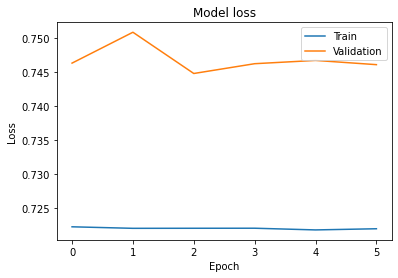

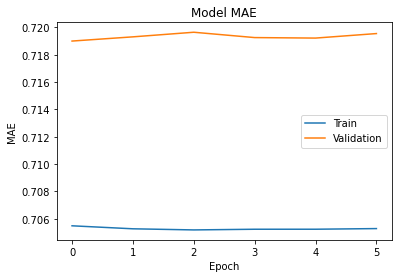

In [73]:
plot_loss_mae(history)

In [74]:
y_pred = model.predict(X_val)
mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
print('RMSE =', math.sqrt(abs(mse)))

RMSE = 0.8630239763264635


## Increase layers

In [75]:
model = Sequential()
model.add(layers.Dense(512, input_dim=55, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               28672     
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                

In [76]:
model.compile(loss='mse',
              optimizer='adam',
              metrics=['mae'])

es = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=32,
                    epochs=2000,
                    callbacks=[es],
                    verbose=1)

Epoch 1/2000
6563/6563 [==============================] - 11s 2ms/step - loss: 1.5018 - mae: 0.8451 - val_loss: 0.8069 - val_mae: 0.7463
Epoch 2/2000
6563/6563 [==============================] - 11s 2ms/step - loss: 0.7852 - mae: 0.7320 - val_loss: 0.7439 - val_mae: 0.7164
Epoch 3/2000
6563/6563 [==============================] - 11s 2ms/step - loss: 0.7750 - mae: 0.7289 - val_loss: 0.7668 - val_mae: 0.7215
Epoch 4/2000
6563/6563 [==============================] - 11s 2ms/step - loss: 0.7689 - mae: 0.7257 - val_loss: 0.8185 - val_mae: 0.7400
Epoch 5/2000
6563/6563 [==============================] - 12s 2ms/step - loss: 0.7629 - mae: 0.7238 - val_loss: 0.7421 - val_mae: 0.7149
Epoch 6/2000
6563/6563 [==============================] - 11s 2ms/step - loss: 0.7586 - mae: 0.7216 - val_loss: 0.7887 - val_mae: 0.7276
Epoch 7/2000
6563/6563 [==============================] - 11s 2ms/step - loss: 0.7558 - mae: 0.7213 - val_loss: 0.7463 - val_mae: 0.7215
Epoch 8/2000
6563/6563 [=================

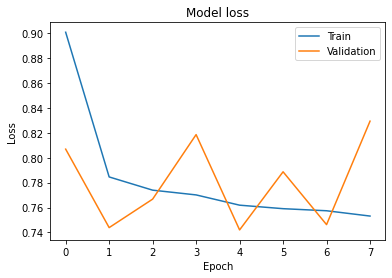

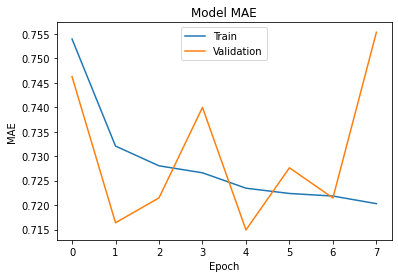

In [77]:
plot_loss_mae(history)

In [78]:
y_pred = model.predict(X_val)
mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
print('RMSE =', math.sqrt(abs(mse)))

RMSE = 0.8614270457998767


## Add regularization

Previous architecture resulted in overfitting; add dropout layers then add regularization to last layers

In [79]:
# Add dropout layers

model = Sequential()
model.add(layers.Dense(512, input_dim=55, activation='relu'))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Dense(1, activation='linear'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 512)               28672     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)               

In [80]:
model.compile(loss='mse',
              optimizer='adam',
              metrics=['mae'])

es = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=32,
                    epochs=2000,
                    callbacks=[es],
                    verbose=1)

Epoch 1/2000
6563/6563 [==============================] - 17s 3ms/step - loss: 4.9557 - mae: 1.6985 - val_loss: 0.7982 - val_mae: 0.7473
Epoch 2/2000
6563/6563 [==============================] - 16s 3ms/step - loss: 1.2092 - mae: 0.8883 - val_loss: 0.7595 - val_mae: 0.7308
Epoch 3/2000
6563/6563 [==============================] - 17s 3ms/step - loss: 0.7996 - mae: 0.7405 - val_loss: 0.7462 - val_mae: 0.7211
Epoch 4/2000
6563/6563 [==============================] - 17s 3ms/step - loss: 0.7580 - mae: 0.7248 - val_loss: 0.7431 - val_mae: 0.7203
Epoch 5/2000
6563/6563 [==============================] - 17s 3ms/step - loss: 0.7556 - mae: 0.7230 - val_loss: 0.7494 - val_mae: 0.7244
Epoch 6/2000
6563/6563 [==============================] - 16s 2ms/step - loss: 0.7572 - mae: 0.7247 - val_loss: 0.7443 - val_mae: 0.7208
Epoch 7/2000
6563/6563 [==============================] - 17s 3ms/step - loss: 0.7512 - mae: 0.7215 - val_loss: 0.7427 - val_mae: 0.7204
Epoch 8/2000
6563/6563 [=================

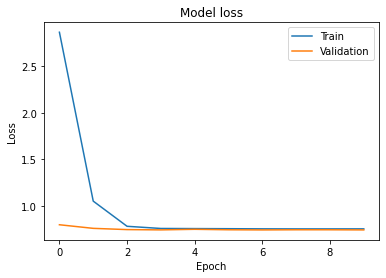

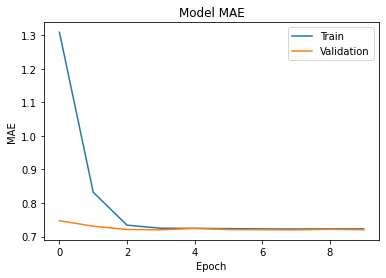

In [81]:
plot_loss_mae(history)

In [82]:
y_pred = model.predict(X_val)
mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
print('RMSE =', math.sqrt(abs(mse)))

RMSE = 0.8618280625337746


In [85]:
# Add regularization

reg_l1 = regularizers.L1(0.01)
reg_l2 = regularizers.L2(0.01)
reg_l1_l2 = regularizers.l1_l2(l1=0.005, l2=0.0005)

model = Sequential()
model.add(layers.Dense(512, input_dim=55, activation='relu'))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Dense(64, activation='relu', kernel_regularizer=reg_l1))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Dense(32, activation='relu', bias_regularizer=reg_l2))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Dense(16, activation='relu', activity_regularizer=reg_l1_l2))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Dense(1, activation='linear'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 512)               28672     
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)               

In [86]:
model.compile(loss='mse',
              optimizer='adam',
              metrics=['mae'])

es = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=32,
                    epochs=2000,
                    callbacks=[es],
                    verbose=1)

Epoch 1/2000
6563/6563 [==============================] - 18s 3ms/step - loss: 7.5745 - mae: 1.8868 - val_loss: 0.9521 - val_mae: 0.7728
Epoch 2/2000
6563/6563 [==============================] - 17s 3ms/step - loss: 1.3132 - mae: 0.8987 - val_loss: 0.7981 - val_mae: 0.7296
Epoch 3/2000
6563/6563 [==============================] - 17s 3ms/step - loss: 0.8158 - mae: 0.7338 - val_loss: 0.7794 - val_mae: 0.7285
Epoch 4/2000
6563/6563 [==============================] - 17s 3ms/step - loss: 0.7860 - mae: 0.7261 - val_loss: 0.7704 - val_mae: 0.7233
Epoch 5/2000
6563/6563 [==============================] - 18s 3ms/step - loss: 0.7795 - mae: 0.7251 - val_loss: 0.7677 - val_mae: 0.7232
Epoch 6/2000
6563/6563 [==============================] - 17s 3ms/step - loss: 0.7764 - mae: 0.7243 - val_loss: 0.7704 - val_mae: 0.7226
Epoch 7/2000
6563/6563 [==============================] - 17s 3ms/step - loss: 0.7793 - mae: 0.7247 - val_loss: 0.7653 - val_mae: 0.7229
Epoch 8/2000
6563/6563 [=================

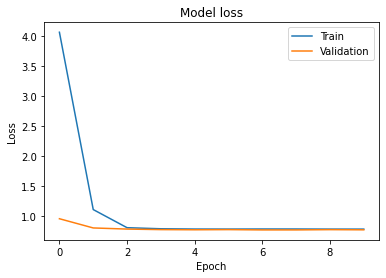

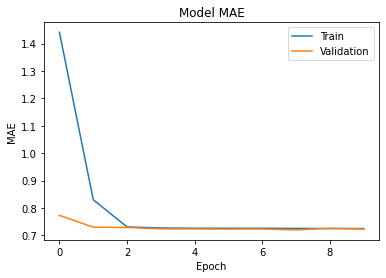

In [87]:
plot_loss_mae(history)

In [88]:
y_pred = model.predict(X_val)
mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
print('RMSE =', math.sqrt(abs(mse)))

RMSE = 0.8638931936677187


In [89]:
# Remove layers

model = Sequential()
model.add(layers.Dense(128, input_dim=55, activation='relu'))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Dense(1, activation='linear'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 128)               7168      
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 16)               

In [90]:
model.compile(loss='mse',
              optimizer='adam',
              metrics=['mae'])

es = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=32,
                    epochs=2000,
                    callbacks=[es],
                    verbose=1)

Epoch 1/2000
6563/6563 [==============================] - 9s 1ms/step - loss: 4.5328 - mae: 1.6279 - val_loss: 0.7825 - val_mae: 0.7392
Epoch 2/2000
6563/6563 [==============================] - 9s 1ms/step - loss: 1.2088 - mae: 0.8862 - val_loss: 0.7623 - val_mae: 0.7310
Epoch 3/2000
6563/6563 [==============================] - 9s 1ms/step - loss: 0.8051 - mae: 0.7417 - val_loss: 0.7442 - val_mae: 0.7208
Epoch 4/2000
6563/6563 [==============================] - 9s 1ms/step - loss: 0.7620 - mae: 0.7267 - val_loss: 0.7489 - val_mae: 0.7234
Epoch 5/2000
6563/6563 [==============================] - 9s 1ms/step - loss: 0.7542 - mae: 0.7224 - val_loss: 0.7451 - val_mae: 0.7212
Epoch 6/2000
6563/6563 [==============================] - 9s 1ms/step - loss: 0.7539 - mae: 0.7226 - val_loss: 0.7434 - val_mae: 0.7184
Epoch 7/2000
6563/6563 [==============================] - 9s 1ms/step - loss: 0.7581 - mae: 0.7254 - val_loss: 0.7446 - val_mae: 0.7214
Epoch 8/2000
6563/6563 [========================

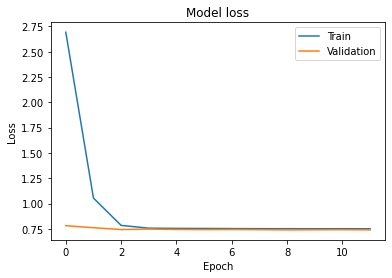

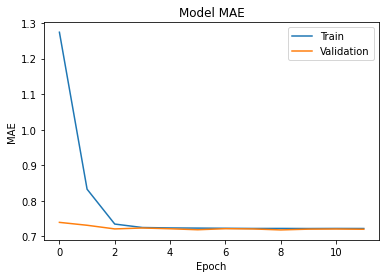

In [91]:
plot_loss_mae(history)